In [9]:
import json
import networkx as nx
from collections import defaultdict
from tqdm import tqdm
import community.community_louvain as community_louvain  # Louvain algorithm
import matplotlib.pyplot as plt

# === Step 1: Load and filter data ===
def load_philadelphia_businesses(path, min_reviews=10):
    businesses = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            business = json.loads(line)
            if (
                business.get("city") == "Philadelphia"
                and business.get("review_count", 0) >= min_reviews
                and business.get("categories")
            ):
                businesses.append({
                    "business_id": business["business_id"],
                    "name": business["name"],
                    "categories": set(map(str.strip, business["categories"].lower().split(',')))
                })
    return businesses

# === Step 2: Compute Jaccard similarity ===
def jaccard(set1, set2):
    intersection = set1 & set2
    union = set1 | set2
    if not union:
        return 0
    return len(intersection) / len(union)

# === Step 3: Create graph ===
def build_similarity_graph(businesses, threshold=0.6):
    G = nx.Graph()
    for i, biz1 in tqdm(enumerate(businesses), total=len(businesses)):
        G.add_node(biz1["business_id"], name=biz1["name"])
        for j in range(i + 1, len(businesses)):
            biz2 = businesses[j]
            similarity = jaccard(biz1["categories"], biz2["categories"])
            if similarity >= threshold:
                G.add_edge(biz1["business_id"], biz2["business_id"], weight=similarity)
    return G

# === Step 4: Community detection ===
def detect_communities(graph):
    partition = community_louvain.best_partition(graph)
    return partition

In [ ]:
import networkx as nx
from networkx.algorithms import community

def contract_communities(G):
    """
    Contracts the input graph into a meta-graph of its communities.
    Each node in the returned graph represents one community (with a 'size' attribute
    equal to the number of original nodes), and edges between these super-nodes have
    weights equal to the sum of inter-community edge weights.
    """
    # 1) Detect communities using greedy modularity maximization
    comms = list(community.greedy_modularity_communities(G))
    # 2) Map each node to its community index
    node2comm = {}
    for i, comm in enumerate(comms):
        for n in comm:
            node2comm[n] = i
    # 3) Build the meta-graph
    H = nx.Graph()
    # Add super-nodes, storing community sizes
    for i, comm in enumerate(comms):
        H.add_node(i, size=len(comm))
    # Add edges between communities, summing weights of original edges
    for u, v, data in G.edges(data=True):
        cu, cv = node2comm[u], node2comm[v]
        if cu == cv:
            continue
        w = data.get('weight', 1.0)
        if H.has_edge(cu, cv):
            H[cu][cv]['weight'] += w
        else:
            H.add_edge(cu, cv, weight=w)
    return H


In [ ]:
import heapq

def top_n_edges_subgraph(G, n=1000):
    """
    Returns a subgraph containing the n edges with the highest weight.
    """
    # Get the n edges with the highest weight
    top_edges = heapq.nlargest(
        n,
        G.edges(data=True),
        key=lambda x: x[2].get('weight', 0)
    )
    # Collect all nodes involved in those edges
    nodes = {u for u, v, _ in top_edges} | {v for u, v, _ in top_edges}
    # Build the subgraph induced by those nodes, restricted to the top edges
    H = G.subgraph(nodes).edge_subgraph([(u, v) for u, v, _ in top_edges]).copy()
    return H


In [ ]:
import networkx as nx

def reduce_by_k_core(G, k=5):
    """
    Returns the k-core of G, i.e. the subgraph where every node
    has degree ≥ k.
    """
    return nx.k_core(G, k)


In [35]:
import networkx as nx

def community_layout(G, communities, k_comm=1.0, k_within=0.2, 
                     scale_communities=5.0, scale_within=1.0, seed=None):
    """
    Build a layout that keeps detected communities apart.

    Parameters
    ----------
    G : networkx.Graph
        The full graph.
    communities : list of sets
        A list of node‐sets, each one is a community.
    k_comm : float
        'k' parameter for the community‐quotient spring layout.
    k_within : float
        'k' parameter for the within‐community spring layouts.
    scale_communities : float
        Scale factor for the overall community positions.
    scale_within : float
        Scale factor for each community’s internal layout.
    seed : int or None
        Random seed for reproducibility.

    Returns
    -------
    pos : dict
        Mapping node → 2D position.
    """
    # 1) Build the community‐quotient graph
    Q = nx.quotient_graph(G, communities, relabel=True)
    # spring‐layout on the quotients (one node per community)
    pos_quot = nx.spring_layout(
        Q, k=k_comm, scale=scale_communities, seed=seed
    )

    # 2) Now lay out each community internally
    pos = {}
    for comm_id, comm_nodes in enumerate(communities):
        subG = G.subgraph(comm_nodes)
        # small‐k to pack the subgraph fairly tight
        pos_sub = nx.spring_layout(
            subG, k=k_within, scale=scale_within, seed=seed
        )
        # offset all positions by the community’s “center”
        offset = pos_quot[comm_id]
        for n, p in pos_sub.items():
            pos[n] = p + offset

    return pos


In [90]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import louvain_communities

def plot_and_save(
    G,
    min_community_size=4,
    k_comm=1.0,
    scale_communities=5.0,
    k_within=0.1,
    scale_within=1.0,
    figsize=(10,10),
    seed=42,
    label_font_size=8,
    show_labels=True,
    output_path=None
):
    """
    Filters to communities of size >= min_community_size, lays out by community,
    draws the graph, optionally labels nodes, and saves to file.

    Parameters
    ----------
    G : networkx.Graph
        The full similarity graph.
    min_community_size : int
        Only communities with at least this many nodes are included.
    k_comm : float
        Spring-layout ‘k’ parameter for inter-community spacing.
    scale_communities : float
        Scale factor for community-quotient layout.
    k_within : float
        Spring-layout ‘k’ parameter for intra-community spacing.
    scale_within : float
        Scale factor for individual community layouts.
    figsize : tuple
        Matplotlib figure size.
    seed : int
        Random seed for reproducibility.
    label_font_size : int
        Font size for node labels.
    show_labels : bool
        Whether to draw node labels (`name` attribute or node ID).
    output_path : str or None
        If provided, saves the figure at this path (e.g. 'with_labels.png').
    """
    # 1) Detect all communities
    all_comms = louvain_communities(G, weight='weight', seed=seed)
    # 2) Keep only the “big” ones
    big_comms = [c for c in all_comms if len(c) >= min_community_size]
    if not big_comms:
        print(f"No communities with ≥{min_community_size} nodes.")
        return

    # 3) Build subgraph of all nodes in the selected communities
    nodes_to_include = set().union(*big_comms)
    G_sub = G.subgraph(nodes_to_include).copy()

    # 4) Compute the two-level community layout
    pos = community_layout(
        G_sub,
        communities=big_comms,
        k_comm=k_comm,
        scale_communities=scale_communities,
        k_within=k_within,
        scale_within=scale_within,
        seed=seed
    )

    # 5) Prepare drawing parameters
    cmap = plt.cm.get_cmap('tab20', len(big_comms))
    node_colors = [
        cmap(ci)
        for ci, comm in enumerate(big_comms)
        for _ in comm
    ]
    # remap by node order
    color_map = {n: cmap(ci) for ci, comm in enumerate(big_comms) for n in comm}

    degrees = dict(G_sub.degree())
    node_sizes = [degrees[n] * 50 for n in G_sub.nodes()]
    edge_widths = [G_sub[u][v].get('weight', 1) * 2 for u, v in G_sub.edges()]

    # 6) Draw edges and nodes
    plt.figure(figsize=figsize)
    nx.draw_networkx_edges(G_sub, pos, width=edge_widths, alpha=0.4)
    nx.draw_networkx_nodes(
        G_sub, pos,
        node_size=node_sizes,
        node_color=[color_map[n] for n in G_sub.nodes()],
        alpha=0.9
    )

    # 7) Optionally draw labels
    if show_labels:
        labels = {n: G_sub.nodes[n].get('name', n) for n in G_sub.nodes()}
        nx.draw_networkx_labels(
            G_sub, pos,
            labels=labels,
            font_size=label_font_size
        )

    plt.axis('off')
    plt.tight_layout()

    # 8) Save to file if requested
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {output_path}")

    plt.show()

In [ ]:

data_path = "Yelp JSON\yelp_dataset\yelp_academic_dataset_business.json"  # Path to your JSON file
businesses = load_philadelphia_businesses(data_path)
print(f"Loaded {len(businesses)} businesses.")

graph = build_similarity_graph(businesses)
print(f"Graph has {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")

# 2) Extract the most dense k-core
G_core = reduce_by_k_core(graph, k=5)
G_reduced = top_n_edges_subgraph(G_core, n=500)


communities = detect_communities(graph)
nx.set_node_attributes(graph, communities, 'community')

Loaded 10457 businesses.


100%|██████████| 10457/10457 [00:34<00:00, 303.74it/s] 


Graph has 10457 nodes and 254532 edges.


/tmp/ipykernel_1345006/69049574.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(big_comms))


Saved figure to graph_with_labels.png


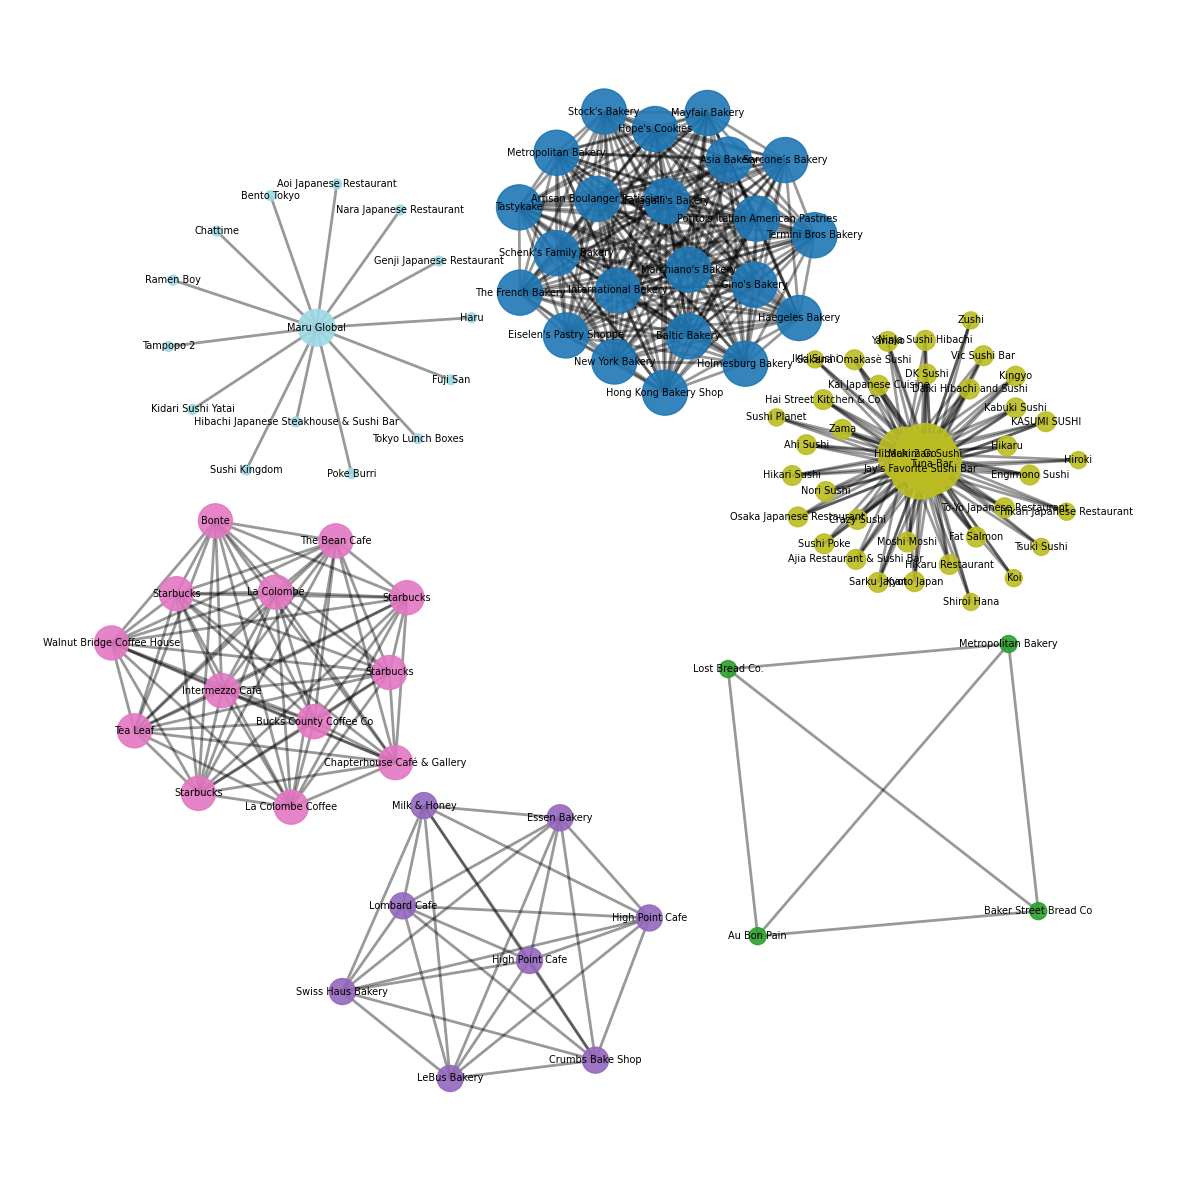

Saved figure to graph_without_labels.png


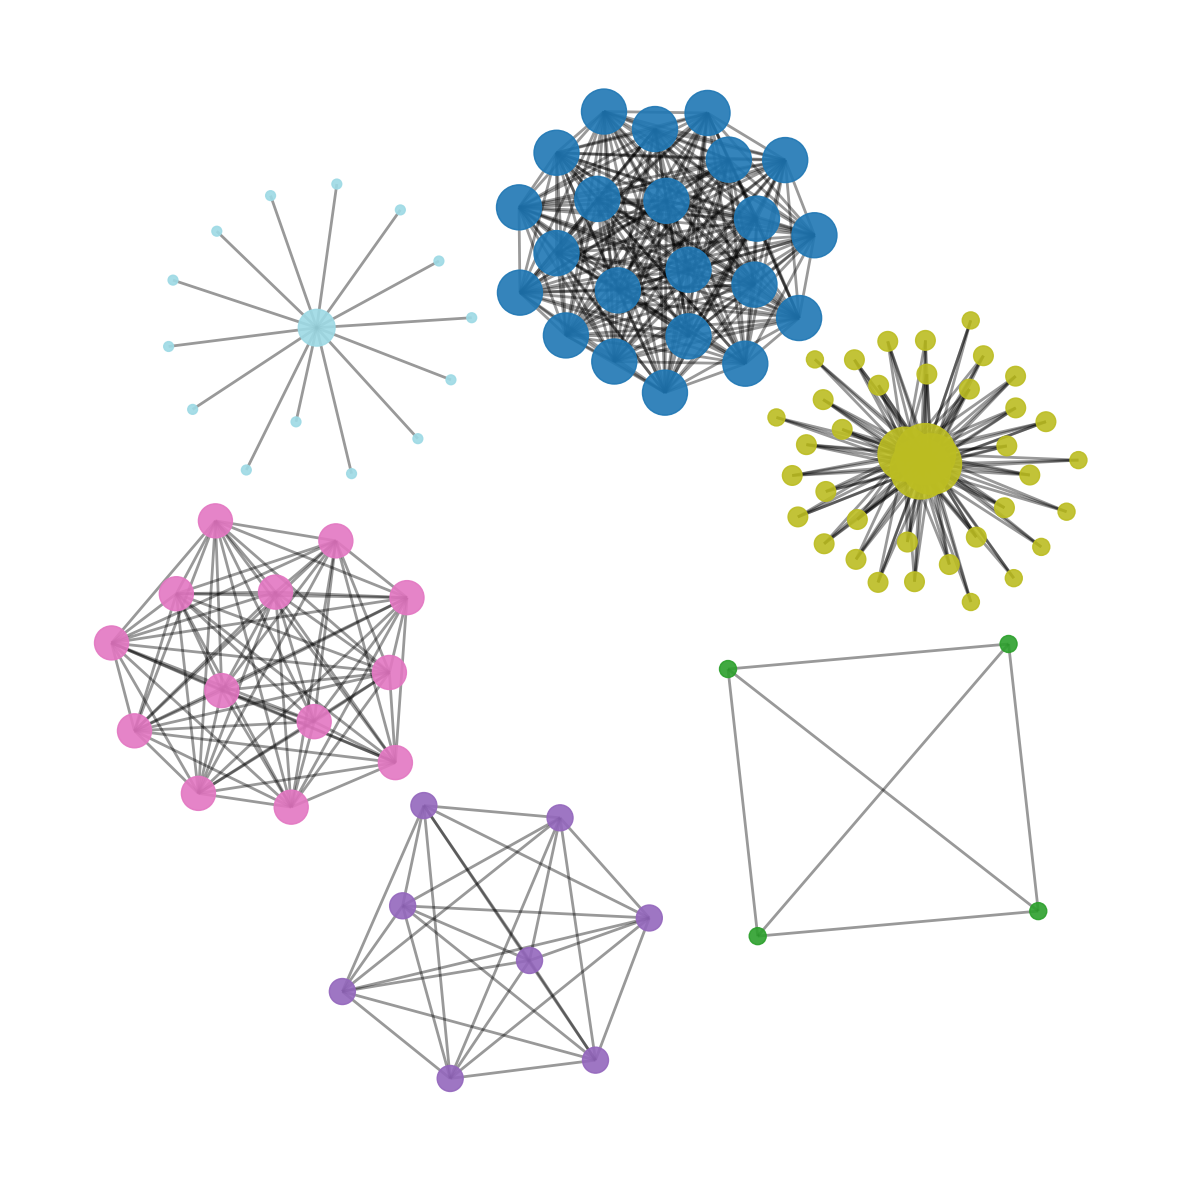

In [ ]:
# Save with labels

plot_and_save(
    G_reduced,
    min_community_size=4,
    k_comm=1.0,
    scale_communities=5.0,
    k_within=0.15,
    scale_within=2.0,
    figsize=(12,12),
    seed=42,
    label_font_size=7,
    show_labels=True,
    output_path='graph_with_labels.png'
)

#Save without labels
plot_and_save(
    G_reduced,
    min_community_size=4,
    k_comm=1.0,
    scale_communities=5.0,
    k_within=0.15,
    scale_within=2.0,
    figsize=(12,12),
    seed=42,
    show_labels=False,
    output_path='graph_without_labels.png'
)


In [17]:
# Save results
nx.write_gexf(graph, "philadelphia_business_communities.gexf")
print("Saved graph with communities to 'philadelphia_business_communities.gexf'.")

Saved graph with communities to 'philadelphia_business_communities.gexf'.


In [18]:
print(max(communities.values()))

930


In [19]:
import networkx as nx
businesses=load_philadelphia_businesses('Yelp JSON\yelp_dataset\yelp_academic_dataset_business.json')
# Load the graph
G = nx.read_gexf("philadelphia_business_communities.gexf")

In [20]:

# Filter for Community 3
print("Businesses in Community :\n")
ids=[]
for node, data in G.nodes(data=True):
    if data.get("community") == 3:
        ids.append(node)
        
for business in businesses:
    if business['business_id'] in ids:
        print(business['categories'])

Businesses in Community :

{'restaurants', 'indian'}
{'restaurants', 'indian'}
{'food', 'cafes', 'restaurants', 'thai', 'cupcakes'}
{'restaurants', 'cajun/creole'}
{'burmese', 'malaysian', 'restaurants', 'thai', 'asian fusion'}
{'food', 'indian', 'buffets', 'restaurants', 'food delivery services', 'halal', 'pakistani'}
{'restaurants', 'soul food', 'seafood', 'southern'}
{'food', 'event planning & services', 'restaurants', 'soul food', 'caterers'}
{'restaurants', 'food', 'seafood'}
{'restaurants', 'barbeque'}
{'restaurants', 'tapas bars'}
{'restaurants', 'indian'}
{'restaurants', 'vietnamese'}
{'restaurants', 'indian'}
{'restaurants', 'indian'}
{'restaurants', 'thai'}
{'restaurants', 'cajun/creole'}
{'restaurants', 'indian', 'vegetarian', 'buffets'}
{'restaurants', 'halal', 'indian', 'pakistani'}
{'restaurants', 'cambodian'}
{'restaurants', 'vietnamese'}
{'restaurants', 'barbeque', 'korean'}
{'restaurants', 'barbeque', 'american (traditional)'}
{'restaurants', 'thai'}
{'food', 'restaura

In [2]:
import networkx as nx
from collections import Counter

# Load your graph with community labels
G = nx.read_gexf("philadelphia_business_communities.gexf")

# Extract community attribute for each node
communities = nx.get_node_attributes(G, "community")

# Count how many nodes in each community
community_counts = Counter(communities.values())

# Print results
for community_id, count in sorted(community_counts.items()):
    print(f"Community {community_id}: {count} businesses")

Community 0: 861 businesses
Community 1: 171 businesses
Community 2: 1 businesses
Community 3: 378 businesses
Community 4: 442 businesses
Community 5: 1014 businesses
Community 6: 562 businesses
Community 7: 1 businesses
Community 8: 1 businesses
Community 9: 1 businesses
Community 10: 78 businesses
Community 11: 340 businesses
Community 12: 325 businesses
Community 13: 170 businesses
Community 14: 272 businesses
Community 15: 6 businesses
Community 16: 1 businesses
Community 17: 196 businesses
Community 18: 133 businesses
Community 19: 35 businesses
Community 20: 1 businesses
Community 21: 109 businesses
Community 22: 1 businesses
Community 23: 128 businesses
Community 24: 195 businesses
Community 25: 279 businesses
Community 26: 1 businesses
Community 27: 142 businesses
Community 28: 261 businesses
Community 29: 478 businesses
Community 30: 200 businesses
Community 31: 14 businesses
Community 32: 1 businesses
Community 33: 47 businesses
Community 34: 96 businesses
Community 35: 1 bus

In [3]:
print(communities)

{'MTSW4McQd7CbVtyjqoe9mw': 0, 'n8ecak12IF_jhnPNs37AZA': 0, 'xruWHK8Z5N0JWyQubLHjgA': 0, 'XpTNCVbO5wL1DtDyKzKqfA': 0, 'HTqXI5S2XcSlh_ylx9sE6g': 0, 'hJnW5-ovJQkecq0EZhHaKw': 0, 'vCHNWdW-ys-nWUx3Cpvk8Q': 0, 'htO_nlxkEsYHzDrtbiUxew': 0, '7hpUoYdAVToZXwuPRgoqdA': 0, 'cOaw7LOj7yjCH9ty8eIJDg': 0, 'IQw4uJsiSzLenDFVnM-DLg': 0, 'mv9uuDPJDaxl0zJ5cEhpXA': 0, 'vhd7sbDlz9gT453ITmCa_Q': 0, '90LsqLbaoQpz_xNbSQsCFA': 0, 'p5pQ5PKXiEc4yLxsL4TsFA': 0, 'JxRSBtTNuLULDfKI3YGQSA': 0, 'Zl8jd_gzZduzMLN4_vUjLw': 0, 'MJCKZqLXluoRRYuAT-SOCQ': 0, 'GZwgmKNS01hEWKQaRTro_A': 0, 'yJw38SIIn9EaQuSSdxRHUA': 0, 'uIFRFef7l43YxA8G3dU6Tg': 0, 'LFOiOxKTB0oDELEJ0yjBhw': 0, 'CHcpcv65XtaGuq4gogzpXQ': 0, 'EQrRwkK6yv44_CEHuoZIQQ': 0, 'FwwbaUc7u5nSiLmkF_Z1Tg': 0, 'Q_pHfuSpVEIVfjJLUSTu3g': 0, '_kaXQwnlsnfpUsKr3otCBg': 0, '2ZSnGlqj8JOWcN2bNf-3SQ': 0, '_Q3XmBesceFqn9Dk-w6tlA': 0, 'TiYGVQxNQ-wkr63o0JwaEA': 0, 'QIEajLDnaNgFrCHWmiXCaQ': 0, 'BcsRUZAeUiU6LSj7Ovtwxw': 0, 'dwkI0-b5PM2-yn-v7j2Agg': 0, 'SaJHvbrvy-ndxLf85mAVXA': 0, 'IMJhGf4nyvrL

In [22]:
import json
from collections import defaultdict
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import networkx as nx

# === Step 1: Load Philadelphia businesses from the graph ===
# G = nx.read_gexf("philadelphia_business_communities.gexf")
business_to_community = {
    node: data['community']
    for node, data in G.nodes(data=True)
}
philly_business_ids = set(business_to_community.keys())

# === Step 2: Prepare time series container ===
community_reviews = defaultdict(lambda: defaultdict(int))

# === Step 3: Process only reviews from Philadelphia businesses ===
def process_reviews(path):
    with open(path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Processing reviews"):
            review = json.loads(line)
            biz_id = review["business_id"]
            if biz_id not in philly_business_ids:
                continue
            date = datetime.strptime(review["date"], "%Y-%m-%d %H:%M:%S").strftime("%Y-%m")
            community_id = business_to_community[biz_id]
            community_reviews[community_id][date] += 1

# === Run the processor ===
process_reviews("Yelp JSON\yelp_dataset\yelp_academic_dataset_review.json")

# === Step 4: Convert to DataFrame for visualization/export ===
dfs = []
for community_id, counts in community_reviews.items():
    df = pd.DataFrame.from_dict(counts, orient="index", columns=[f"Community_{community_id}"])
    df.index = pd.to_datetime(df.index)
    dfs.append(df.sort_index())

# === Step 5: Merge all communities into one time series table ===
review_timeseries_df = pd.concat(dfs, axis=1).fillna(0).astype(int)
review_timeseries_df.to_csv("community_review_timeseries_philadelphia.csv")
print("Saved filtered time series to 'community_review_timeseries_philadelphia.csv'.")


Processing reviews: 6990280it [01:44, 66913.09it/s] 


Saved filtered time series to 'community_review_timeseries_philadelphia.csv'.


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the previously saved time series CSV
df = pd.read_csv("community_review_timeseries_philadelphia.csv", index_col=0, parse_dates=True)

['Community_0', 'Community_1', 'Community_10', 'Community_100', 'Community_101', 'Community_102', 'Community_103', 'Community_104', 'Community_105', 'Community_106', 'Community_107', 'Community_108', 'Community_109', 'Community_11', 'Community_110', 'Community_111', 'Community_112', 'Community_113', 'Community_114', 'Community_115', 'Community_116', 'Community_117', 'Community_118', 'Community_119', 'Community_12', 'Community_120', 'Community_121', 'Community_122', 'Community_123', 'Community_124', 'Community_125', 'Community_126', 'Community_127', 'Community_128', 'Community_129', 'Community_13', 'Community_130', 'Community_131', 'Community_132', 'Community_133', 'Community_134', 'Community_135', 'Community_136', 'Community_137', 'Community_138', 'Community_139', 'Community_14', 'Community_140', 'Community_141', 'Community_142', 'Community_143', 'Community_144', 'Community_145', 'Community_146', 'Community_147', 'Community_148', 'Community_149', 'Community_15', 'Community_150', 'Commu

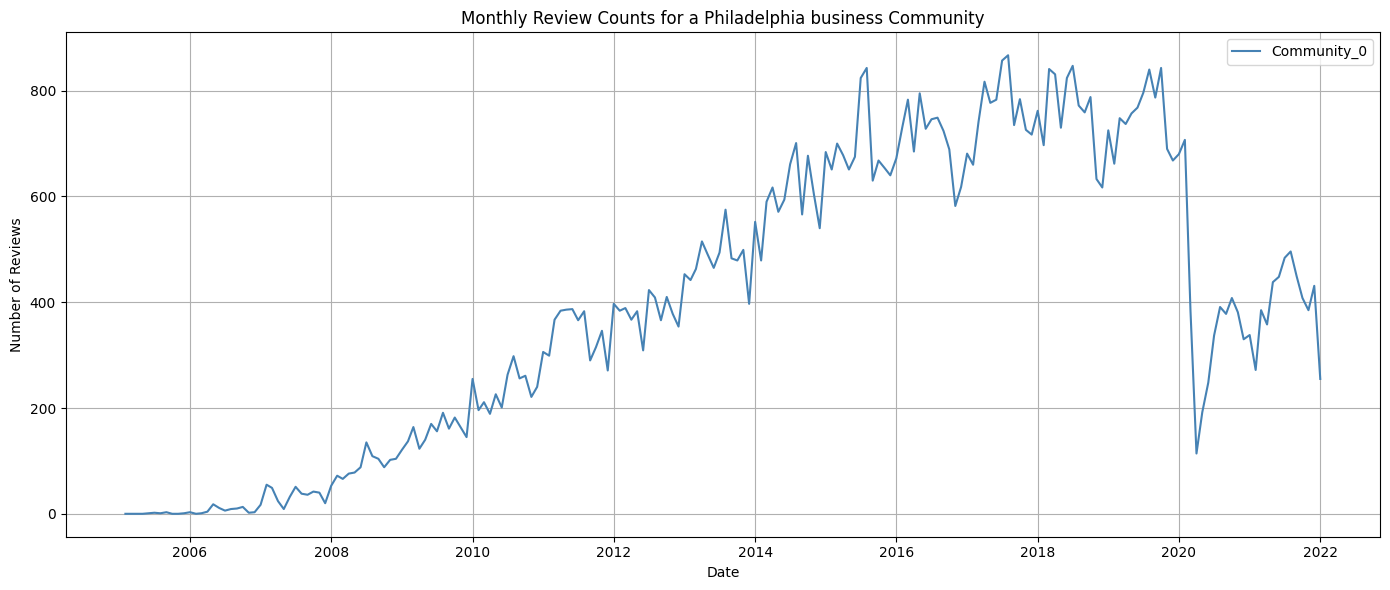

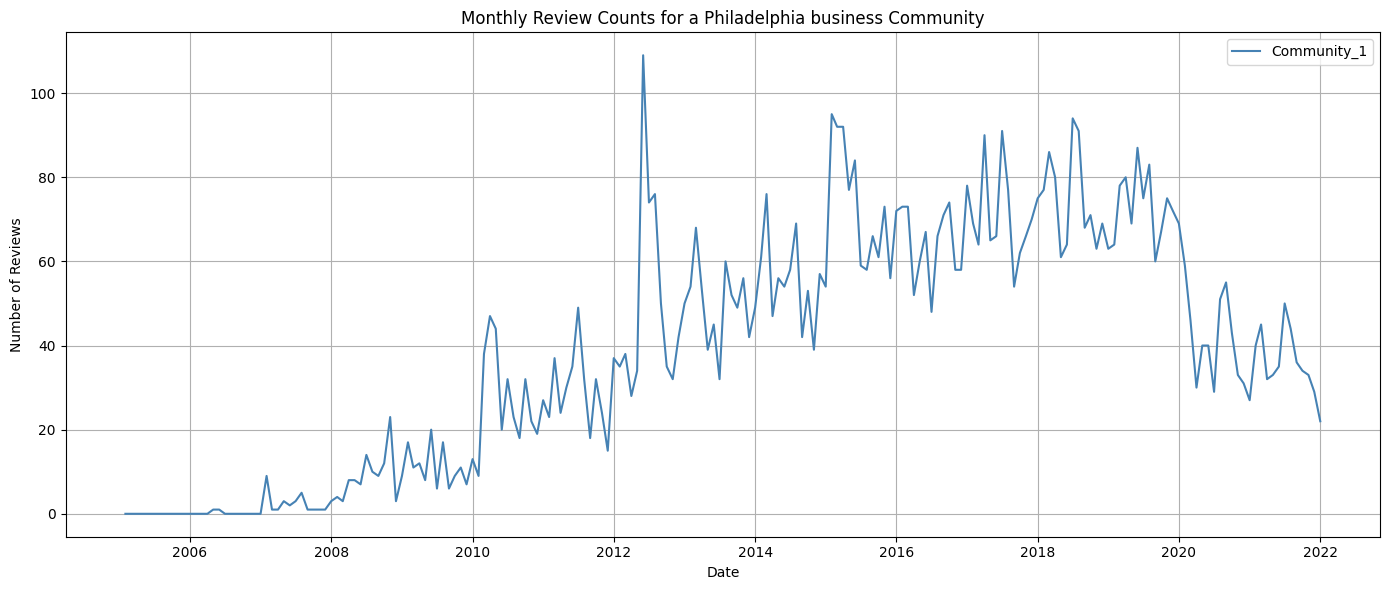

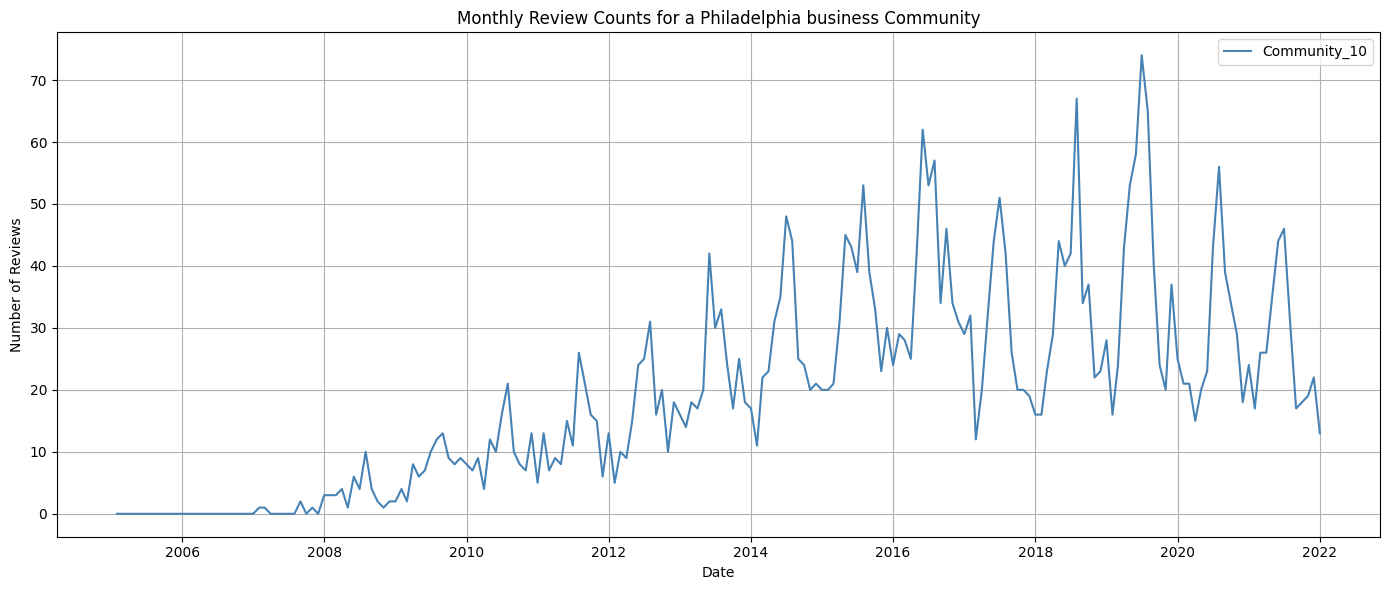

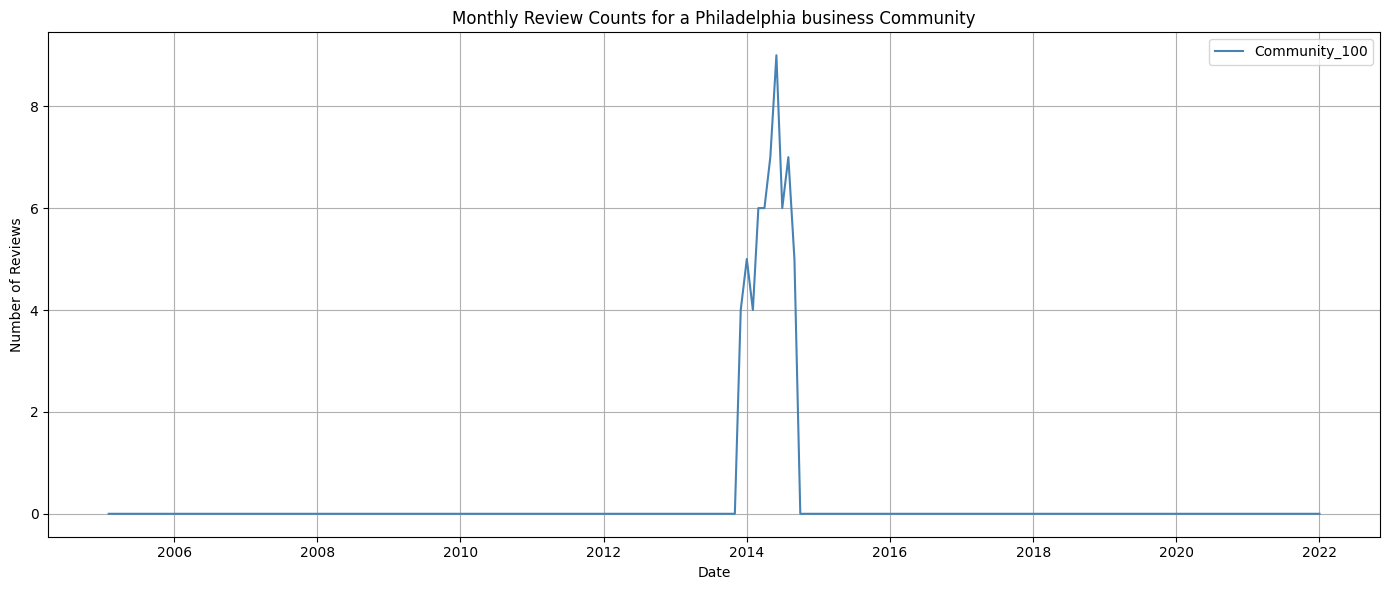

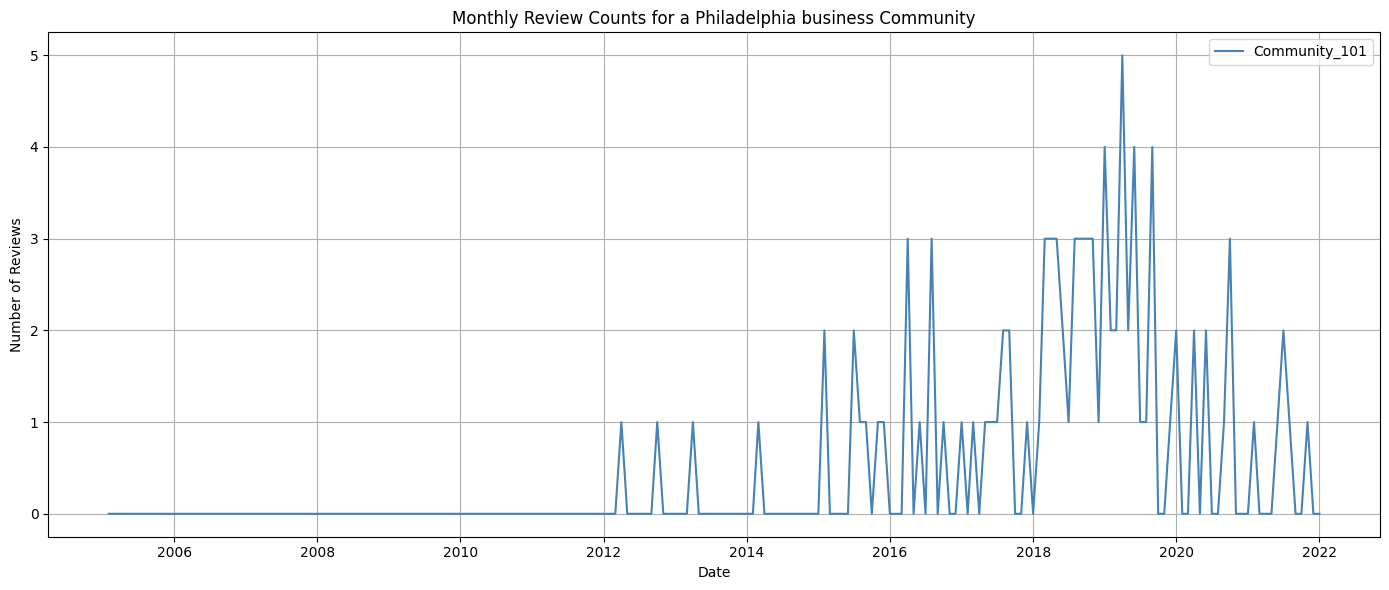

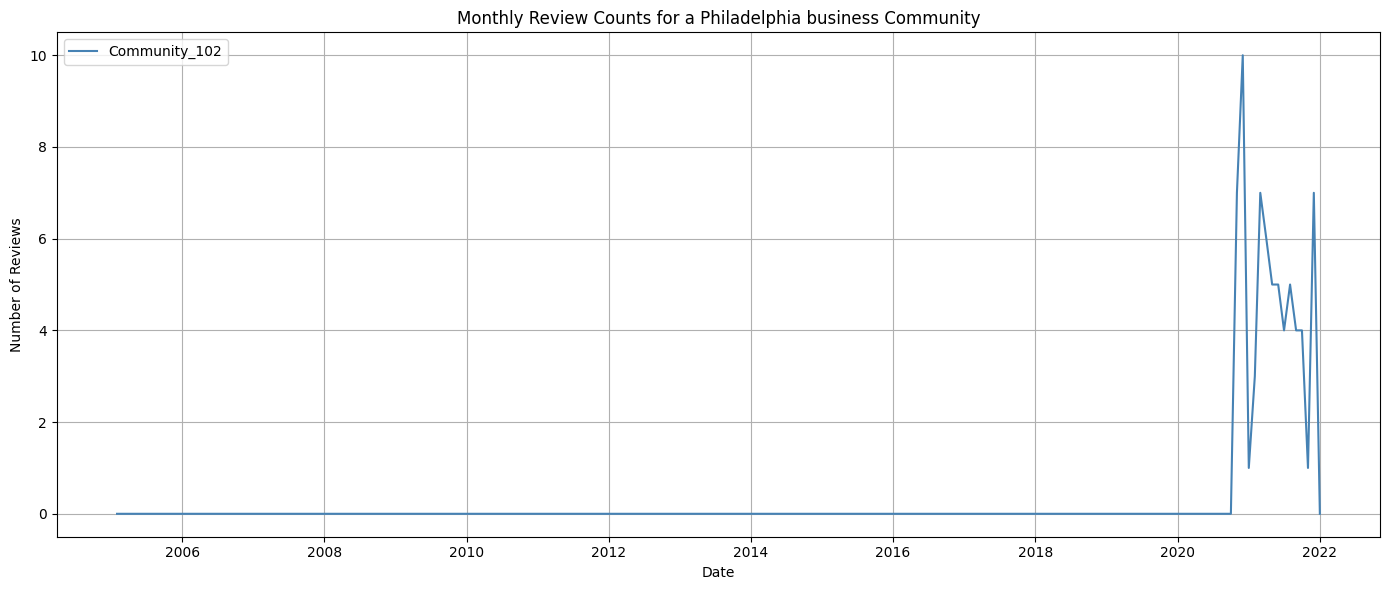

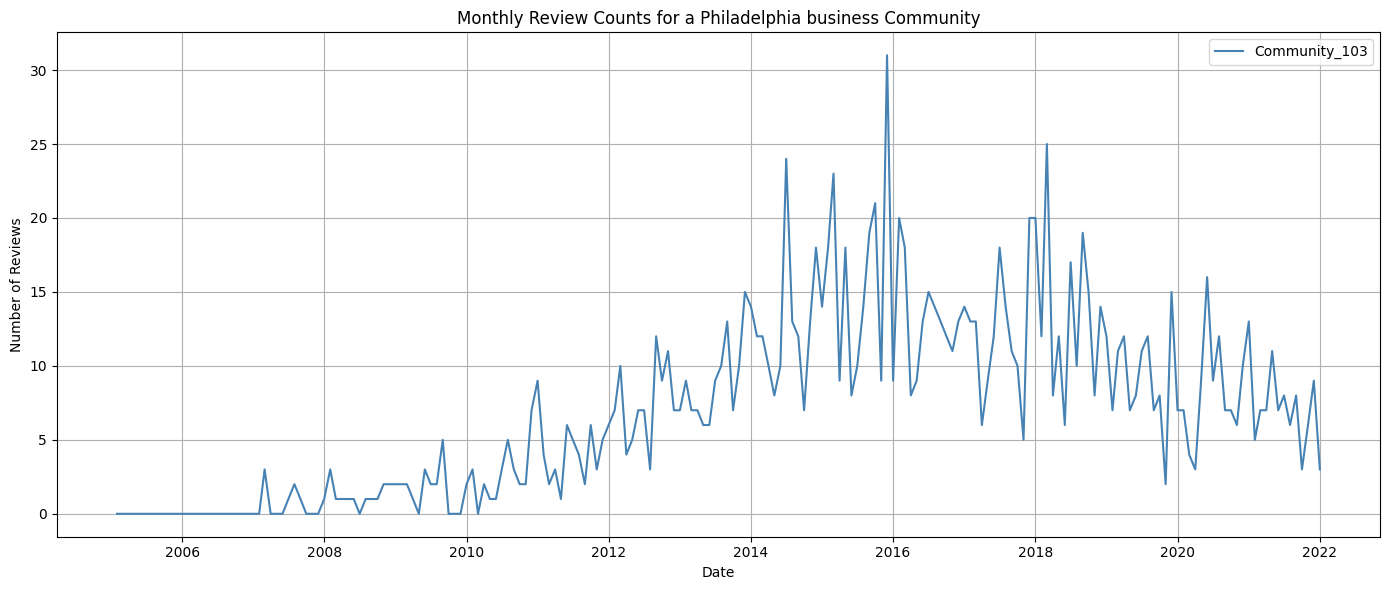

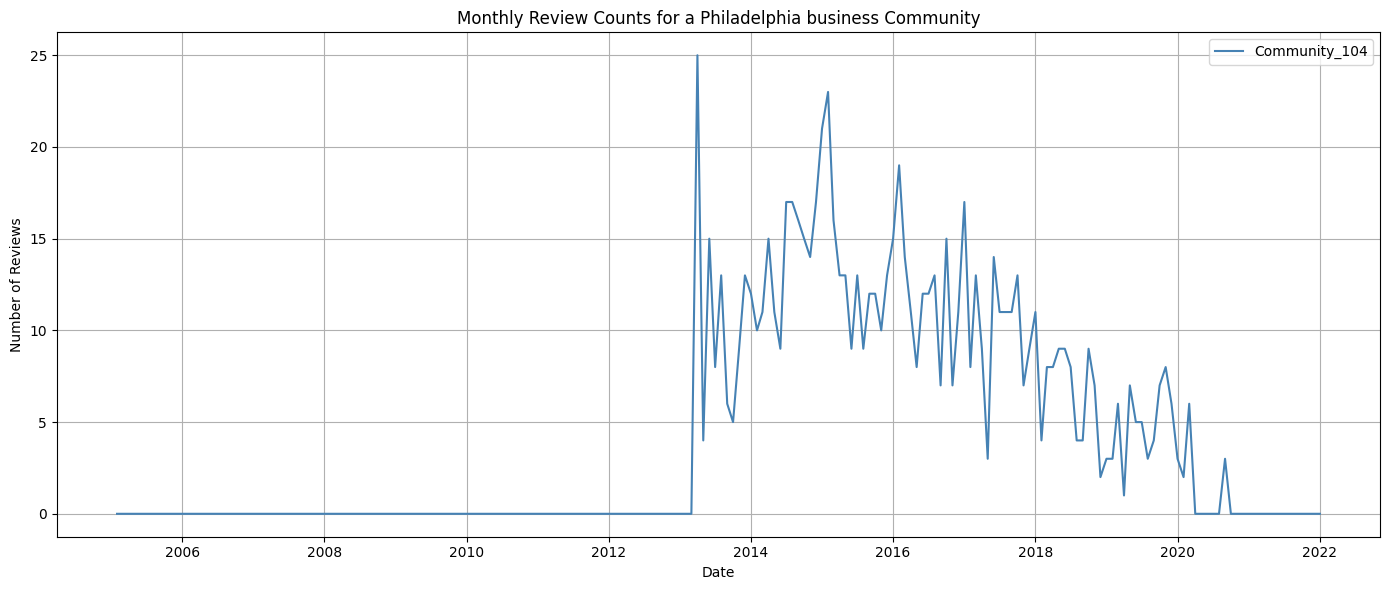

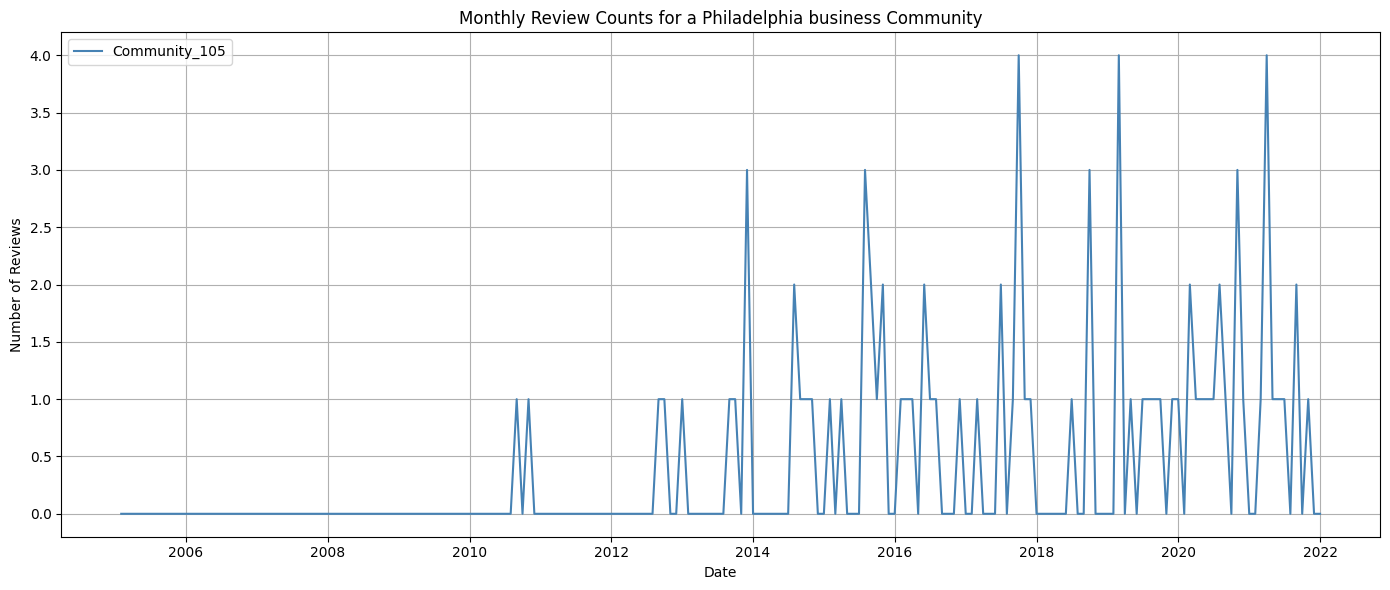

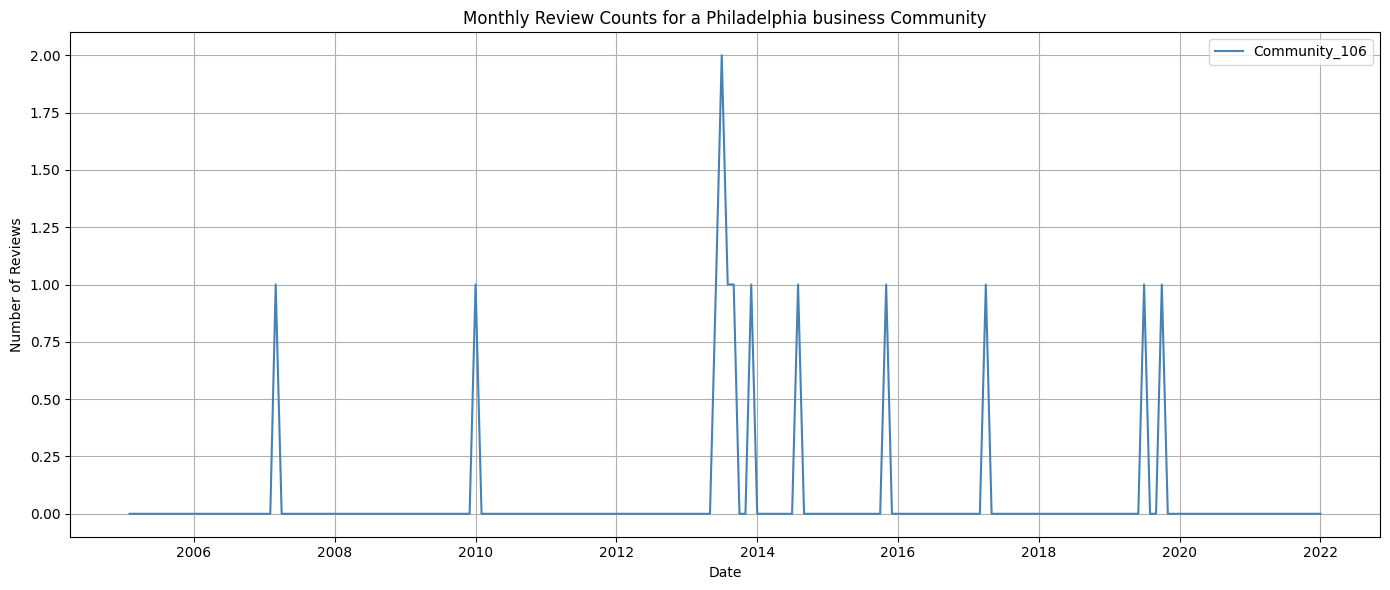

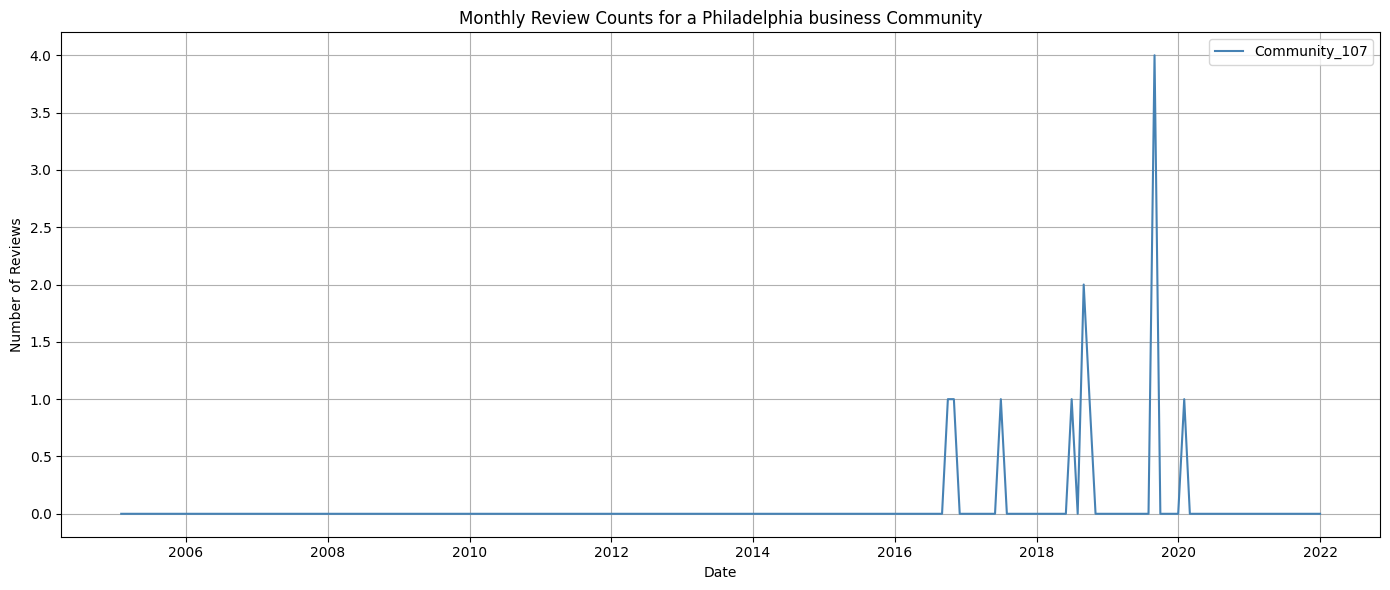

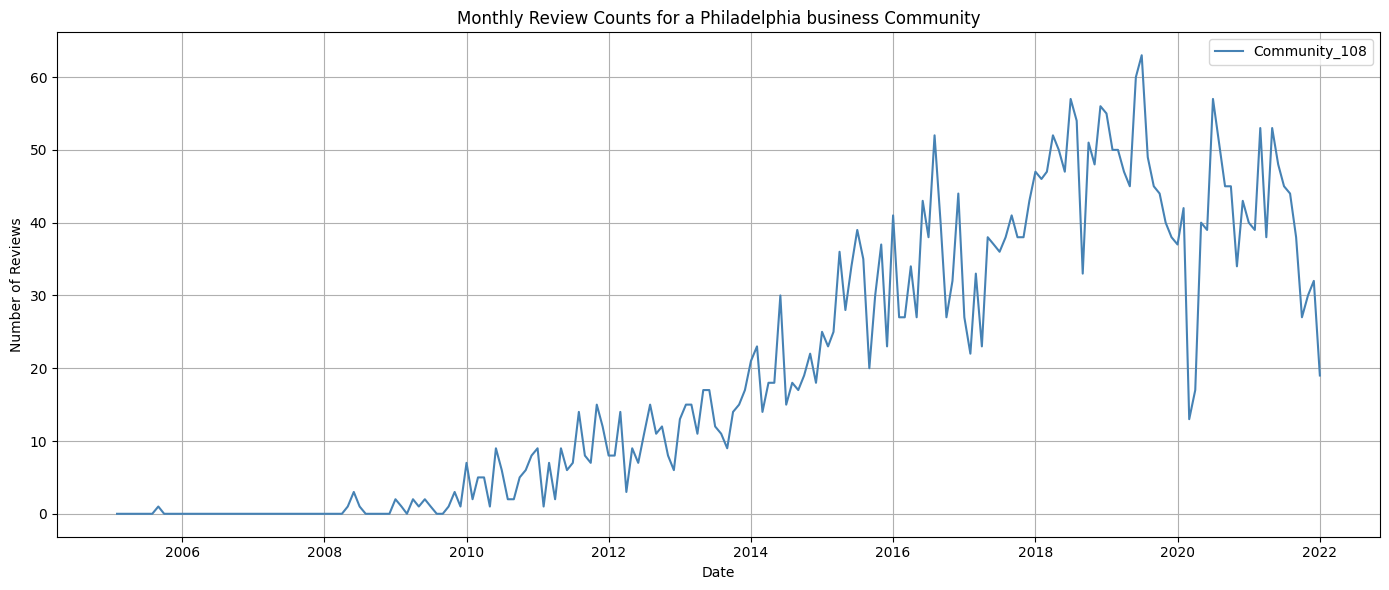

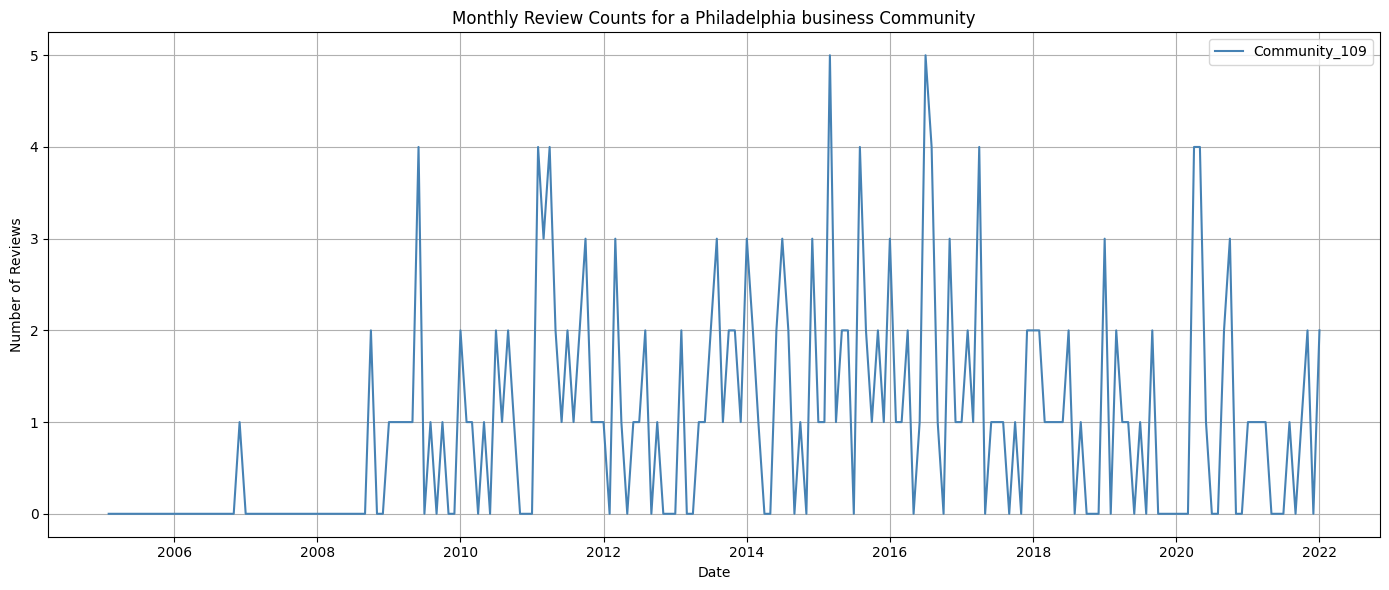

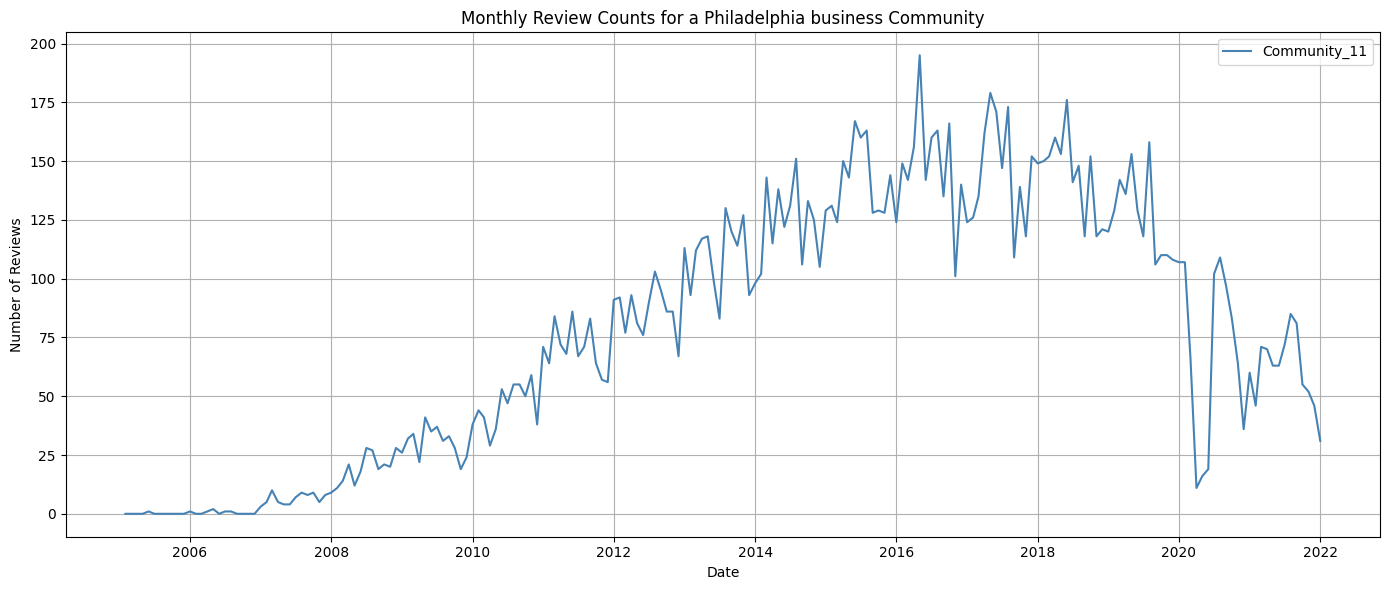

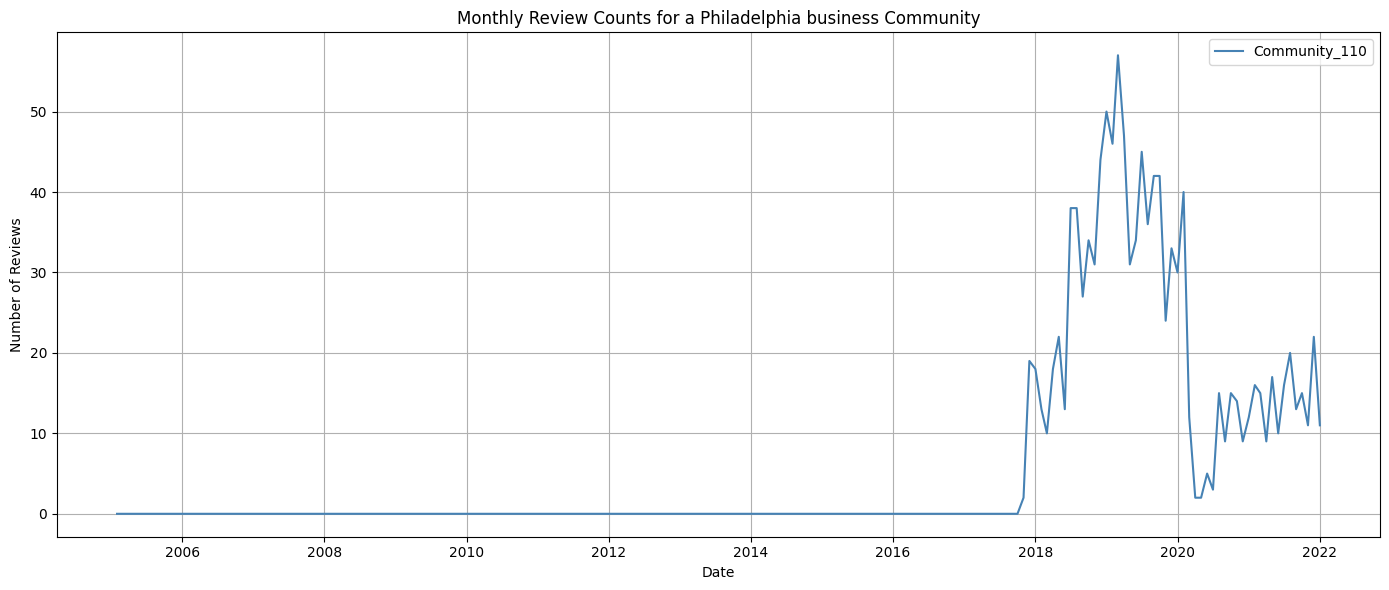

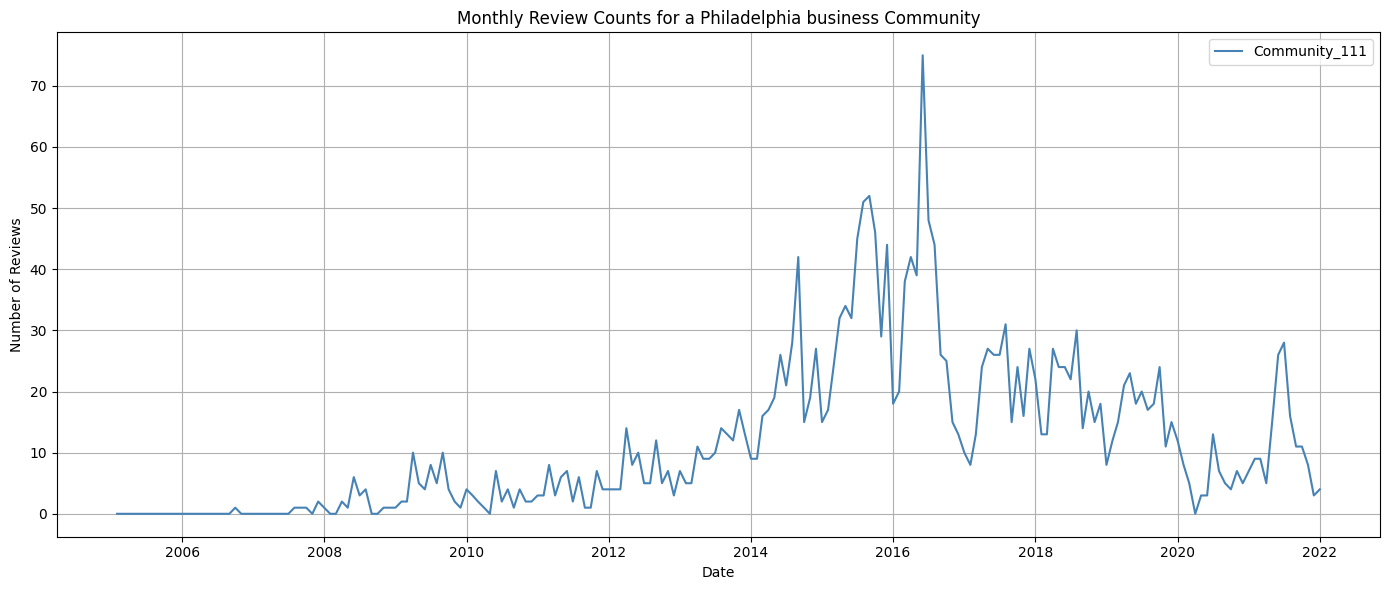

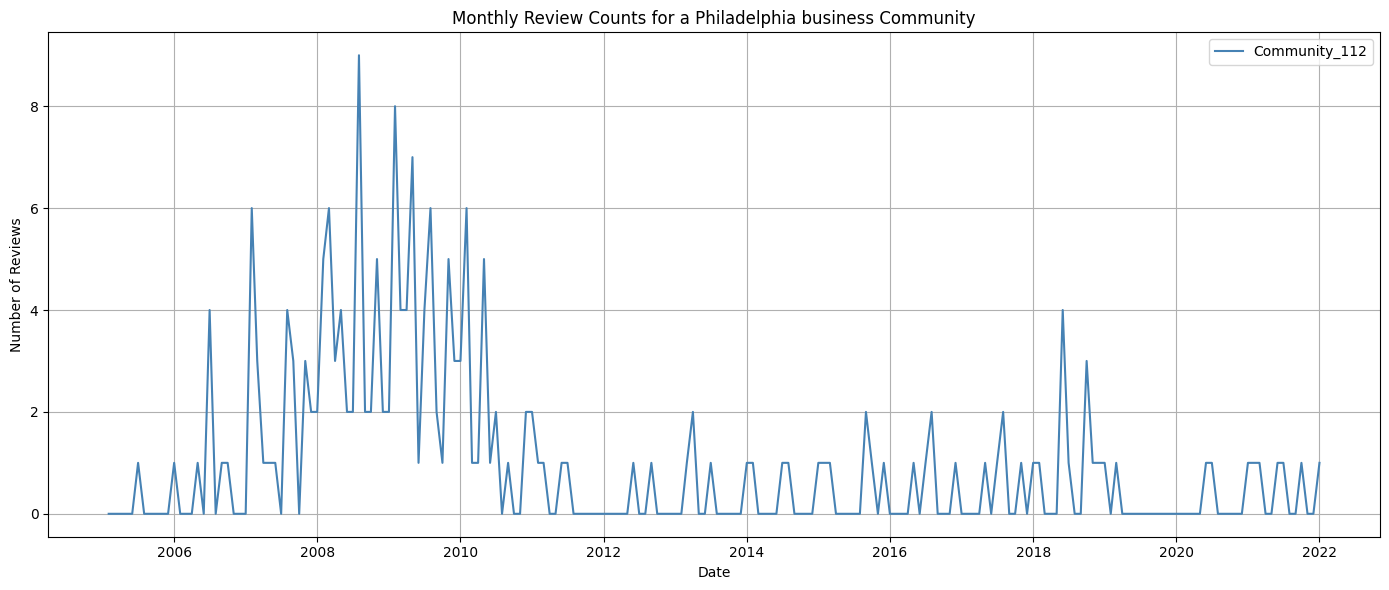

In [23]:


# Sort columns to get consistent "first two" communities
columns = sorted(df.columns)
print(columns)
for i in range(17):
    # Select first two communities
    community_1 = columns[i]
   
    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df[community_1], label=community_1, color='steelblue')

    plt.title("Monthly Review Counts for a Philadelphia business Community")
    plt.xlabel("Date")
    plt.ylabel("Number of Reviews")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


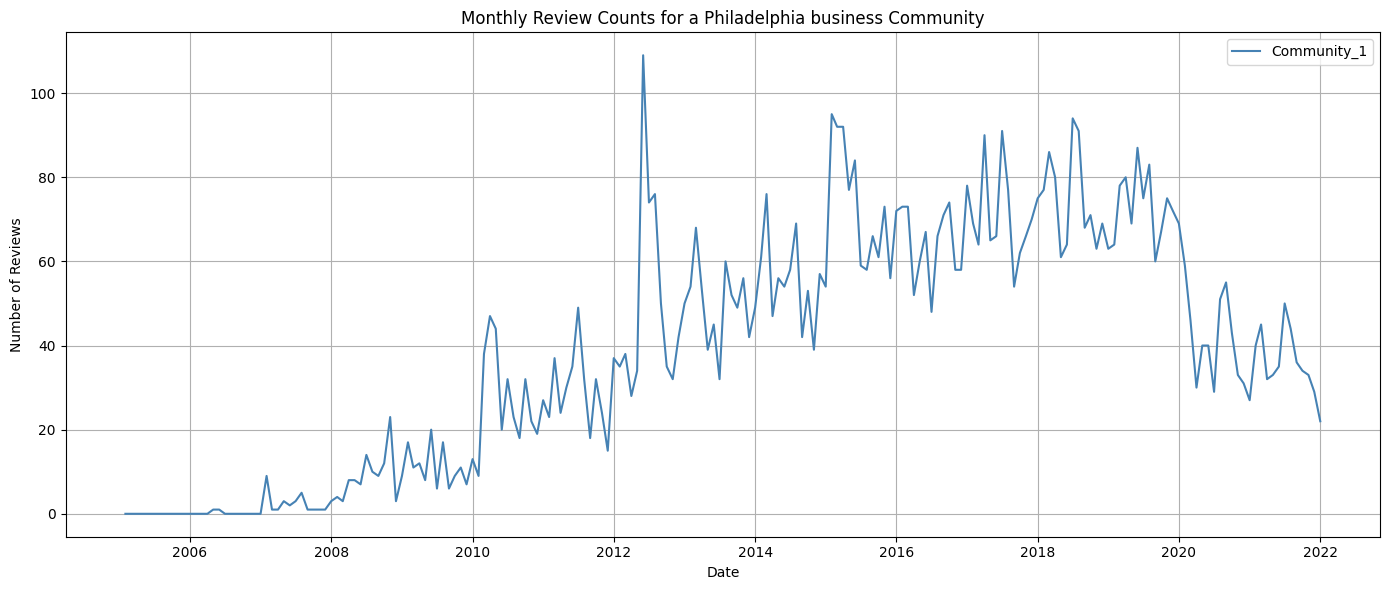

In [ ]:
# Select first community
community_1 = columns[1]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df.index, df[community_1], label=community_1, color='steelblue')

plt.title("Monthly Review Counts for a Philadelphia business Community")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

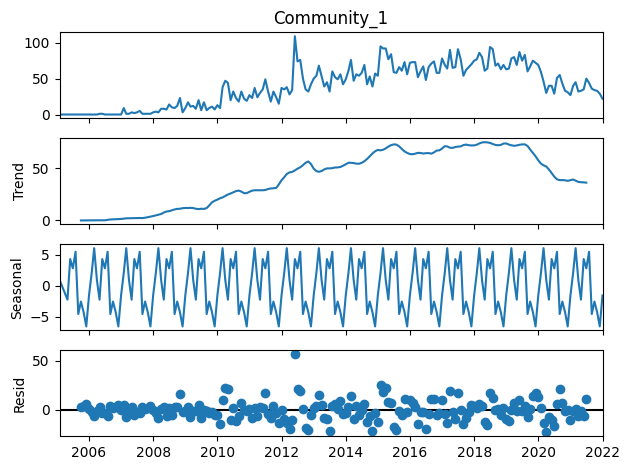

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Time series decomposition in Python
result = seasonal_decompose(df['Community_1'], model='additive', period=12)
result.plot();

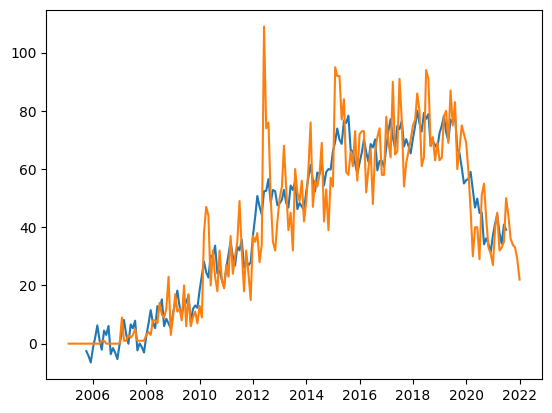

In [63]:
plt.plot((result.trend + result.seasonal))
plt.plot(result.observed)
plt.show()

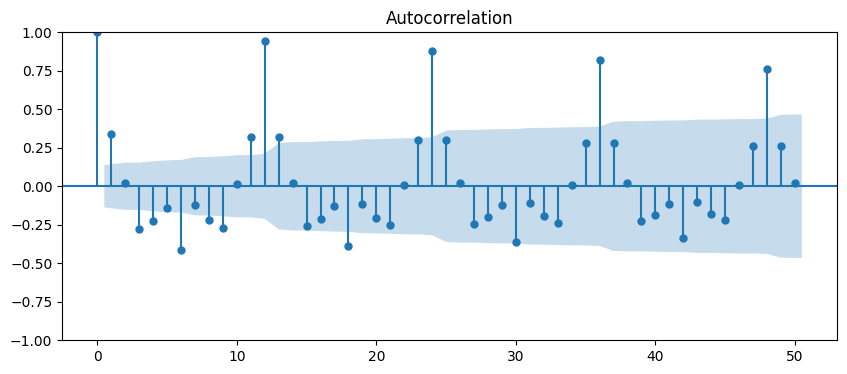

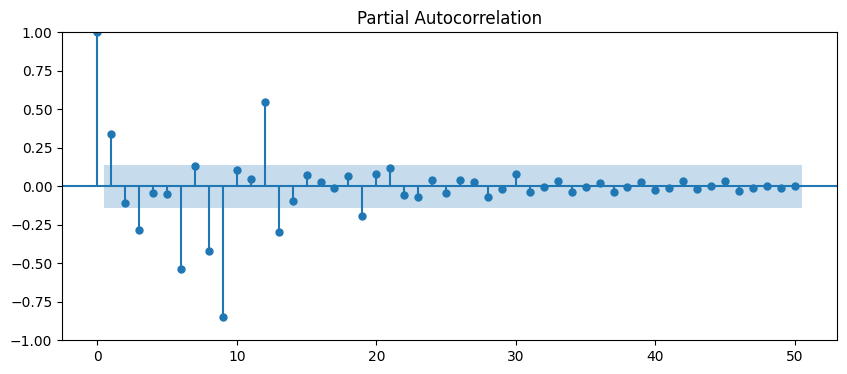

In [65]:
from statsmodels.graphics.tsaplots import plot_acf

# Draw Plot
_, ax = plt.subplots(figsize=(10,4), dpi= 100)
plot_acf((result.seasonal).tolist(), lags=50, ax=ax);
# TODO
from statsmodels.graphics.tsaplots import plot_pacf

_, ax = plt.subplots(figsize=(10,4), dpi= 100)
plot_pacf(result.seasonal.tolist(), lags=50, ax=ax);

In [26]:
from statsmodels.tsa.stattools import adfuller

# Assuming 'df' is your DataFrame and 'Community_1' is the column of interest
series = df['Community_1'].dropna()  # Ensure there are no missing values

# Perform the Augmented Dickey-Fuller test
result = adfuller(series)

# Extract and display the test statistic and p-value
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpret the result
if result[1] <= 0.05:
    print("Conclusion: The time series is stationary (reject the null hypothesis).")
else:
    print("Conclusion: The time series is non-stationary (fail to reject the null hypothesis).")


ADF Statistic: -1.5944865660365928
p-value: 0.4863624936017298
Conclusion: The time series is non-stationary (fail to reject the null hypothesis).


In [27]:
diff_series= df['Community_1'].diff()
# Perform the Augmented Dickey-Fuller test
series=diff_series.dropna()
result = adfuller(series)

# Extract and display the test statistic and p-value
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpret the result
if result[1] <= 0.05:
    print("Conclusion: The time series is stationary (reject the null hypothesis).")
else:
    print("Conclusion: The time series is non-stationary (fail to reject the null hypothesis).")

ADF Statistic: -9.410867700787119
p-value: 5.840339343081436e-16
Conclusion: The time series is stationary (reject the null hypothesis).


<Axes: >

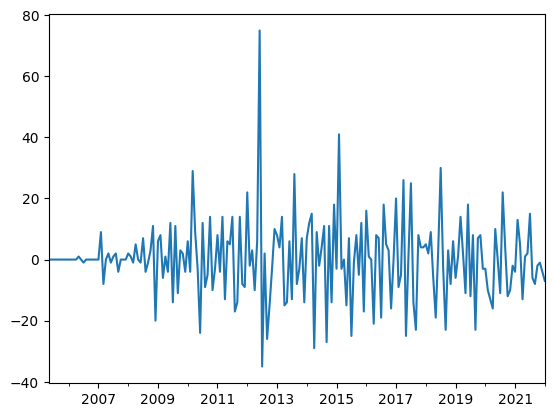

In [28]:
series.plot()

ETS MODEL

C:\Users\azizb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


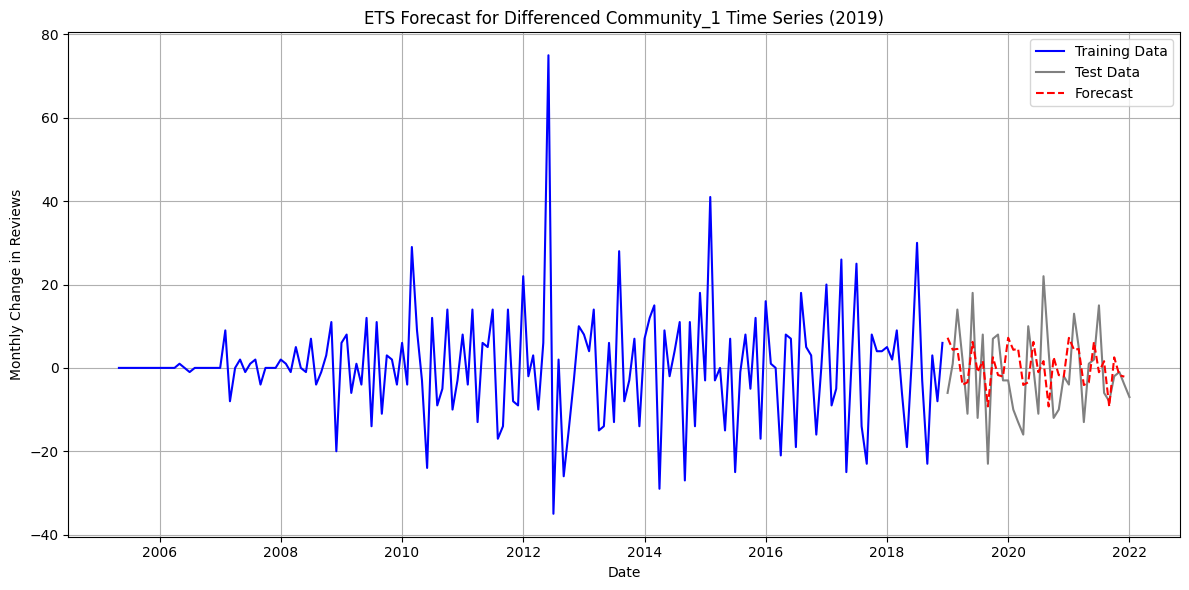

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Step 1: Compute the first-order difference
diff_series = df['Community_1'].diff().dropna()

# Step 2: Split the data
train = diff_series[:'2018']
test = diff_series['2019':]

# Step 3: Fit the ETS model (additive trend, no seasonality)
model = ExponentialSmoothing(train, trend='add', seasonal='add')
fit = model.fit()

# Step 4: Forecast the next 12 months
forecast = fit.forecast(steps=36)

# Step 5: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='gray')
plt.plot(forecast.index, forecast, label='Forecast', color='red', linestyle='--')
plt.title('ETS Forecast for Differenced Community_1 Time Series (2019)')
plt.xlabel('Date')
plt.ylabel('Monthly Change in Reviews')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


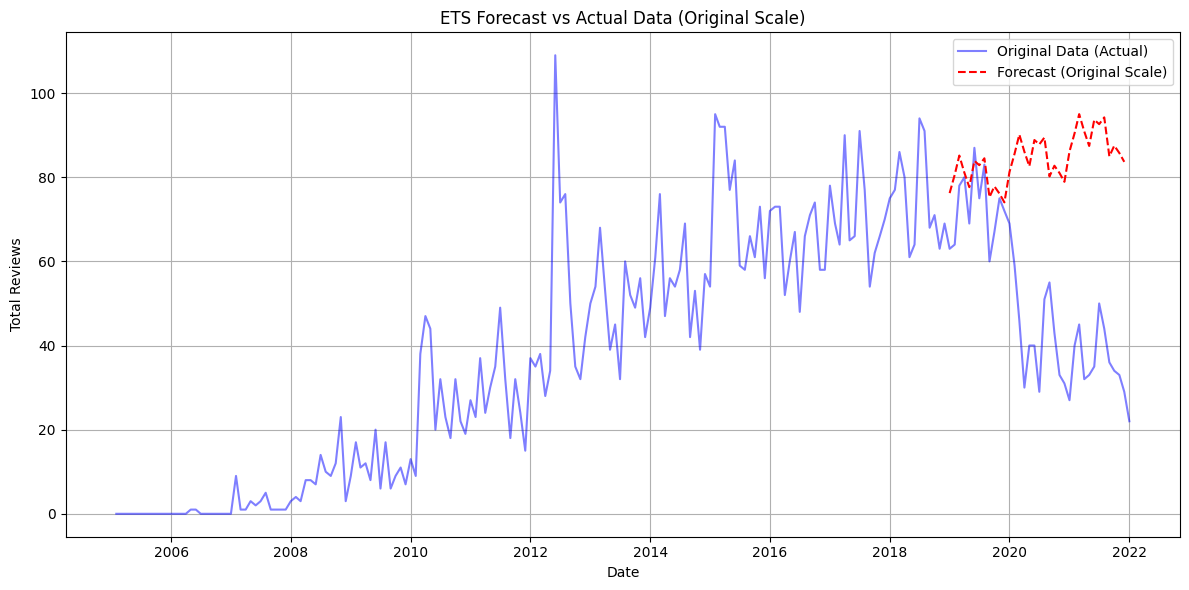

In [30]:


# === NEW SECTION: Inverse transform the forecast back to original scale ===

# Get the last known real value before the forecast starts (Dec 2018)
last_real_value = df['Community_1'].loc['2018-12-01']

# Reconstruct the forecast in original scale
forecast_original_scale = forecast.cumsum() + last_real_value

# Slice the real data to compare (same period as forecast)
real_data = df['Community_1'].loc[forecast_original_scale.index.min():forecast_original_scale.index.max()]

# Step 5: Plot both
plt.figure(figsize=(12, 6))
plt.plot(df['Community_1'], label='Original Data (Actual)', color='blue', alpha=0.5)
plt.plot(forecast_original_scale, label='Forecast (Original Scale)', color='red', linestyle='--')
plt.title('ETS Forecast vs Actual Data (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Total Reviews')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# === Step 1: Define the test period ===
# We evaluate from Jan 2019 to Dec 2019 (12 months after Dec 2018)
eval_start = '2019-01-01'
eval_end = '2019-12-01'

# === Step 2: Get the true values and forecast for that range ===
true_values = df['Community_1'].loc[eval_start:eval_end]
forecast_eval = forecast_original_scale.loc[eval_start:eval_end]

# === Step 3: Calculate error metrics ===
mae = mean_absolute_error(true_values, forecast_eval)
rmse = np.sqrt(mean_squared_error(true_values, forecast_eval))
mape = np.mean(np.abs((true_values - forecast_eval) / true_values)) * 100

# === Step 4: Print results ===
print("ETS Forecast Evaluation (2019)")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


ETS Forecast Evaluation (2019)
MAE:  7.37
RMSE: 9.16
MAPE: 10.98%


C:\Users\azizb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\azizb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\azizb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


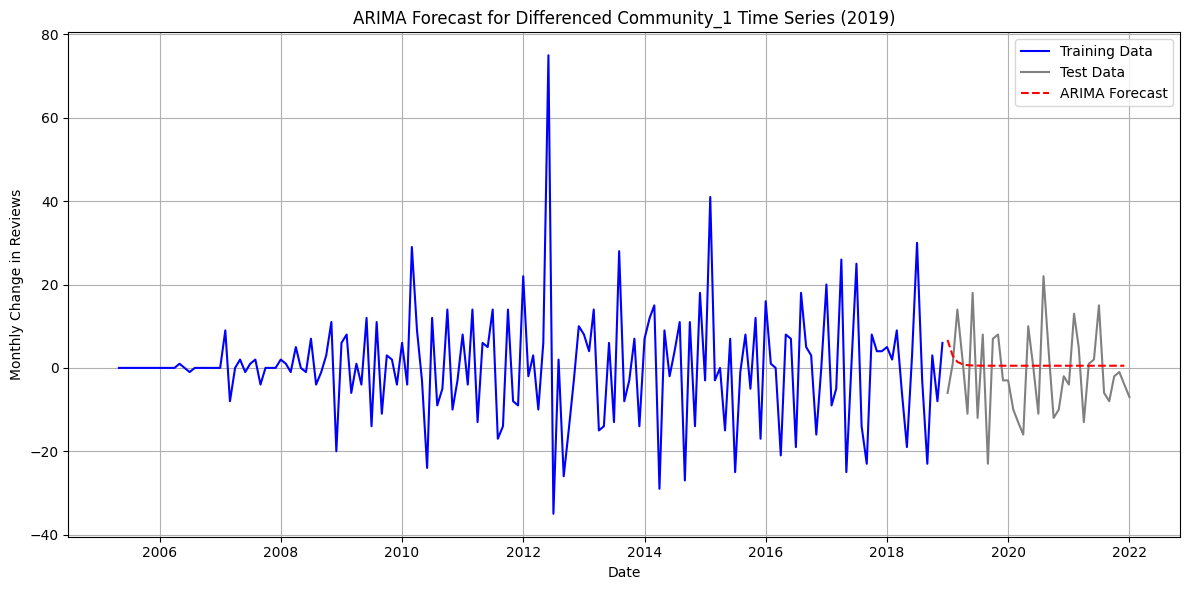

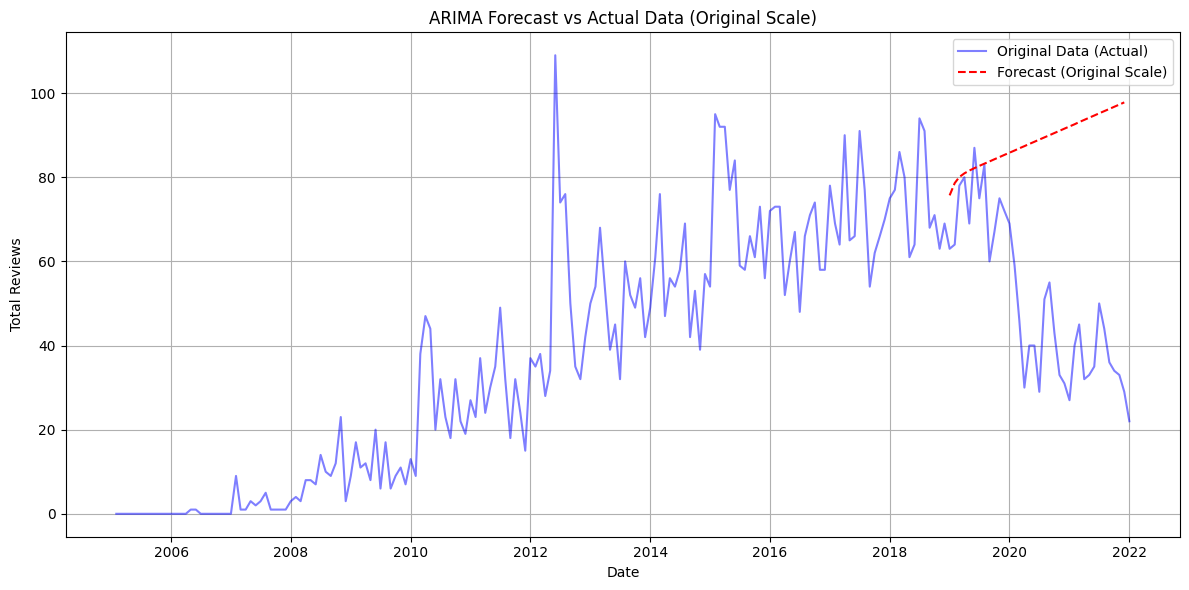

ARIMA Forecast Evaluation (2019)
MAE:  9.98
RMSE: 12.10
MAPE: 14.84%


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Step 1: Compute the first-order difference (if not already done)
diff_series = df['Community_1'].diff().dropna()

# Step 2: Split the data into training and testing sets
train = diff_series[:'2018']
test = diff_series['2019':]

# Step 3: Fit the ARIMA model
# Since the series is stationary, we set d=0
model = ARIMA(train, order=(1, 0, 1))  # You can adjust p and q as needed
fit = model.fit()

# Step 4: Forecast the next 12 months
forecast = fit.forecast(steps=36)

# Step 5: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='gray')
plt.plot(forecast.index, forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.title('ARIMA Forecast for Differenced Community_1 Time Series (2019)')
plt.xlabel('Date')
plt.ylabel('Monthly Change in Reviews')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === NEW SECTION: Inverse transform the forecast back to original scale ===

# Get the last known real value before the forecast starts (Dec 2018)
last_real_value = df['Community_1'].loc['2018-12-01']

# Reconstruct the forecast in original scale
forecast_original_scale = forecast.cumsum() + last_real_value

# Slice the real data to compare (same period as forecast)
real_data = df['Community_1'].loc[forecast_original_scale.index.min():forecast_original_scale.index.max()]

# Step 5: Plot both
plt.figure(figsize=(12, 6))
plt.plot(df['Community_1'], label='Original Data (Actual)', color='blue', alpha=0.5)
plt.plot(forecast_original_scale, label='Forecast (Original Scale)', color='red', linestyle='--')
plt.title('ARIMA Forecast vs Actual Data (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Total Reviews')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# We evaluate from Jan 2019 to Dec 2019 (12 months after Dec 2018)
eval_start = '2019-01-01'
eval_end = '2019-12-01'

# === Step 2: Get the true values and forecast for that range ===
true_values = df['Community_1'].loc[eval_start:eval_end]
forecast_eval = forecast_original_scale.loc[eval_start:eval_end]

# === Step 3: Calculate error metrics ===
mae = mean_absolute_error(true_values, forecast_eval)
rmse = np.sqrt(mean_squared_error(true_values, forecast_eval))
mape = np.mean(np.abs((true_values - forecast_eval) / true_values)) * 100

# === Step 4: Print results ===
print("ARIMA Forecast Evaluation (2019)")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")



C:\Users\azizb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\azizb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\azizb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\azizb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

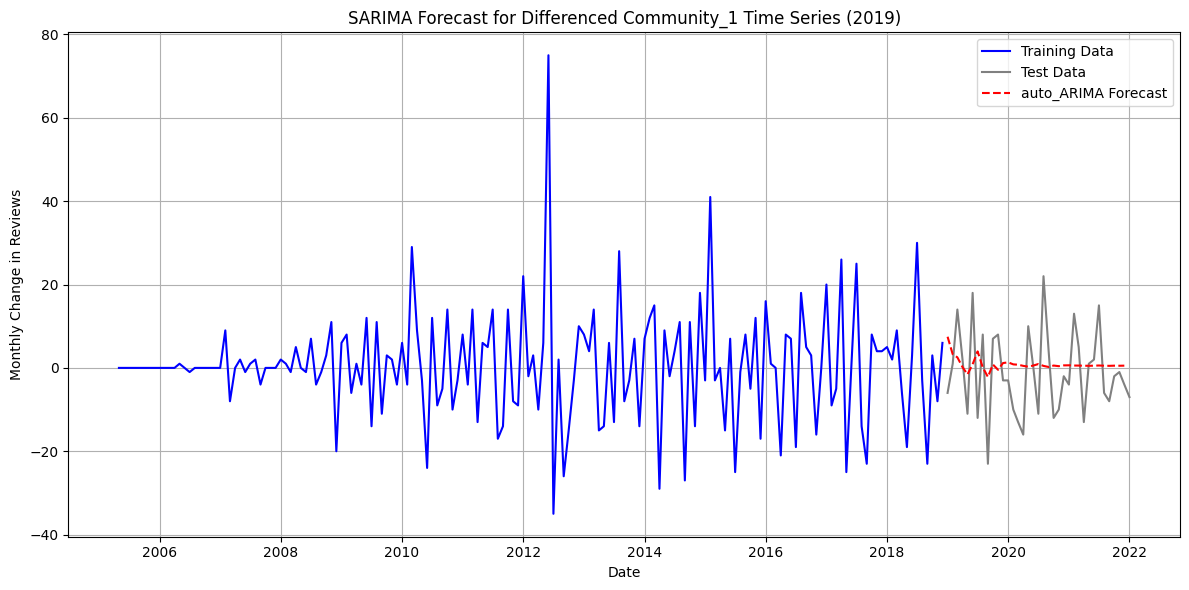

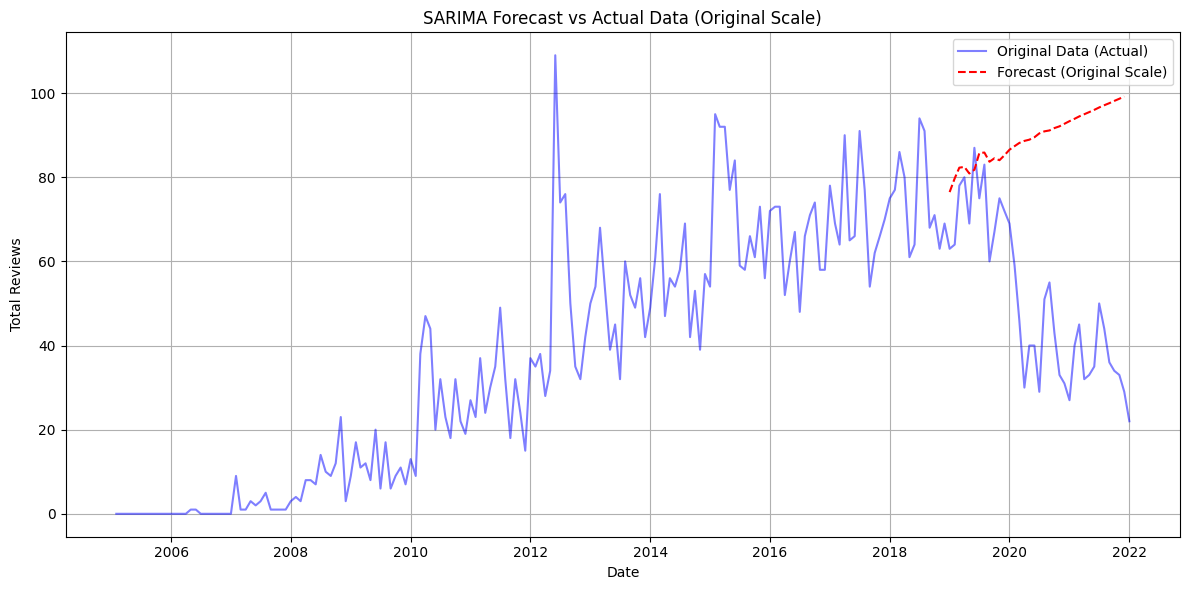

SARIMA Forecast Evaluation (2019)
MAE:  10.85
RMSE: 12.49
MAPE: 15.97%


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Step 1: Compute the first-order difference
diff_series = df['Community_1'].diff().dropna()

# Step 2: Split the data into training and testing sets
train = diff_series[:'2018']
test = diff_series['2019':]



model = auto_arima(train, seasonal=True, m=12, stepwise=True)
forecast = model.predict(n_periods=36)

# Step 5: Create a forecast index matching the test period
forecast_index = pd.date_range(start='2019-01-01', periods=36, freq='MS')
forecast_series = pd.Series(forecast, index=forecast_index)

# Step 6: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='gray')
plt.plot(forecast_series.index, forecast_series, label='auto_ARIMA Forecast', color='red', linestyle='--')
plt.title('SARIMA Forecast for Differenced Community_1 Time Series (2019)')
plt.xlabel('Date')
plt.ylabel('Monthly Change in Reviews')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === NEW SECTION: Inverse transform the forecast back to original scale ===

# Get the last known real value before the forecast starts (Dec 2018)
last_real_value = df['Community_1'].loc['2018-12-01']

# Reconstruct the forecast in original scale
forecast_original_scale = forecast.cumsum() + last_real_value

# Slice the real data to compare (same period as forecast)
real_data = df['Community_1'].loc[forecast_original_scale.index.min():forecast_original_scale.index.max()]

# Step 5: Plot both
plt.figure(figsize=(12, 6))
plt.plot(df['Community_1'], label='Original Data (Actual)', color='blue', alpha=0.5)
plt.plot(forecast_original_scale, label='Forecast (Original Scale)', color='red', linestyle='--')
plt.title('SARIMA Forecast vs Actual Data (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Total Reviews')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# We evaluate from Jan 2019 to Dec 2019 (12 months after Dec 2018)
eval_start = '2019-01-01'
eval_end = '2019-12-01'

# === Step 2: Get the true values and forecast for that range ===
true_values = df['Community_1'].loc[eval_start:eval_end]
forecast_eval = forecast_original_scale.loc[eval_start:eval_end]

# === Step 3: Calculate error metrics ===
mae = mean_absolute_error(true_values, forecast_eval)
rmse = np.sqrt(mean_squared_error(true_values, forecast_eval))
mape = np.mean(np.abs((true_values - forecast_eval) / true_values)) * 100

# === Step 4: Print results ===
print("SARIMA Forecast Evaluation (2019)")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")



16:49:48 - cmdstanpy - INFO - Chain [1] start processing
16:49:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\azizb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


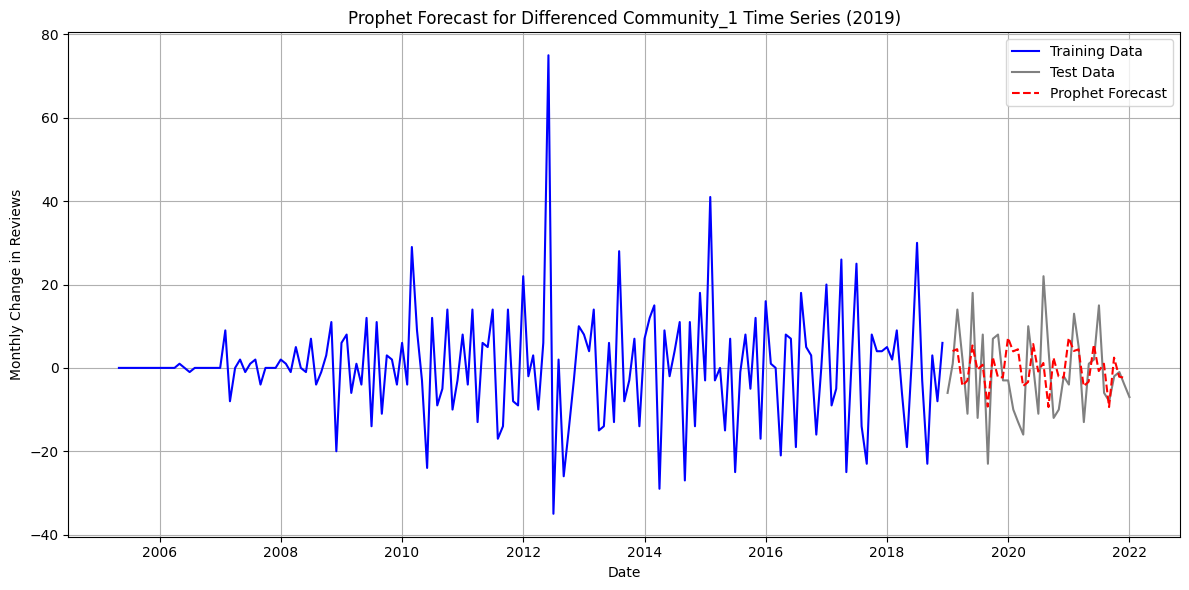

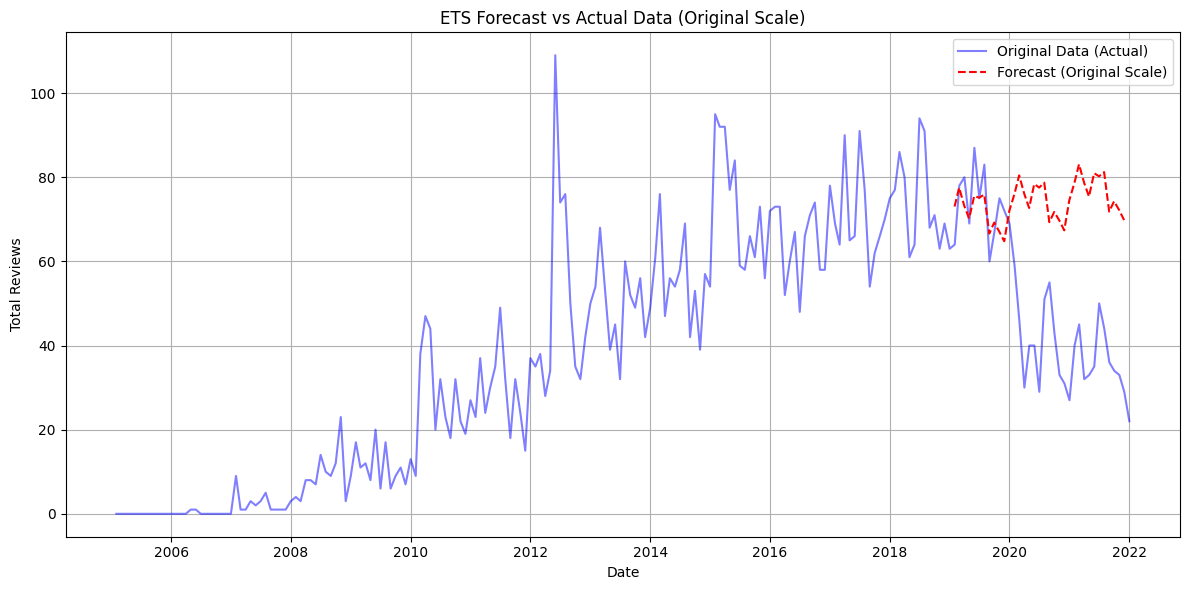

Prophet Forecast Evaluation (2019)
MAE:  10.04
RMSE: 10.04
MAPE: 15.93%


In [35]:
from prophet import Prophet
import pandas as pd


# Step 1: Prepare the data
df_train = train.reset_index()
df_train.columns = ['ds', 'y']

# Step 2: Fit the Prophet model
model = Prophet()
model.fit(df_train)

# Step 3: Create a future dataframe for 12 months ahead
future = model.make_future_dataframe(periods=36, freq='M')

# Step 4: Generate the forecast
forecast = model.predict(future)

# Step 5: Extract the forecasted values
forecast_series = forecast.set_index('ds')['yhat'].loc['2019-01-01':'2021-12-01']

# Step 6: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='gray')
plt.plot(forecast_series.index, forecast_series, label='Prophet Forecast', color='red', linestyle='--')
plt.title('Prophet Forecast for Differenced Community_1 Time Series (2019)')
plt.xlabel('Date')
plt.ylabel('Monthly Change in Reviews')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === NEW SECTION: Inverse transform the forecast back to original scale ===

# Get the last known real value before the forecast starts (Dec 2018)
last_real_value = df['Community_1'].loc['2018-12-01']

# Reconstruct the forecast in original scale
forecast_original_scale = forecast_series.cumsum() + last_real_value

# Slice the real data to compare (same period as forecast)
real_data = df['Community_1'].loc[forecast_original_scale.index.min():forecast_original_scale.index.max()]

# Step 5: Plot both
plt.figure(figsize=(12, 6))
plt.plot(df['Community_1'], label='Original Data (Actual)', color='blue', alpha=0.5)
plt.plot(forecast_original_scale, label='Forecast (Original Scale)', color='red', linestyle='--')
plt.title('ETS Forecast vs Actual Data (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Total Reviews')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# We evaluate from Jan 2019 to Dec 2019 (12 months after Dec 2018)
eval_start = '2019-01-01'
eval_end = '2019-01-31'

# === Step 2: Get the true values and forecast for that range ===
true_values = df['Community_1'].loc[eval_start:eval_end]
forecast_eval = forecast_original_scale.loc[eval_start:eval_end]

# === Step 3: Calculate error metrics ===
mae = mean_absolute_error(true_values, forecast_eval)
rmse = np.sqrt(mean_squared_error(true_values, forecast_eval))
mape = np.mean(np.abs((true_values.values - forecast_eval.values) / true_values)) * 100

# === Step 4: Print results ===
print("Prophet Forecast Evaluation (2019)")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")




In [36]:

import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# === Step 1: Choose your business ID ===
target_business_id1 = 'MTSW4McQd7CbVtyjqoe9mw'  # Replace with your business_id
target_business_id2= 'xruWHK8Z5N0JWyQubLHjgA'
business_name1='St Honore Pastries'
business_name2="Potito's Italian American Pastries"
# === Step 2: Extract all review dates for that business ===
review_dates1 = []
review_dates2 = []

with open("Yelp JSON\yelp_dataset\yelp_academic_dataset_review.json", 'r', encoding='utf-8') as f:
    for line in f:
        review = json.loads(line)
        if review["business_id"] == target_business_id1:
            # Convert to monthly period
            review_date = pd.to_datetime(review["date"]).to_period("M")
            review_dates1.append(review_date)
        if review["business_id"] == target_business_id2:
            # Convert to monthly period
            review_date = pd.to_datetime(review["date"]).to_period("M")
            review_dates2.append(review_date)





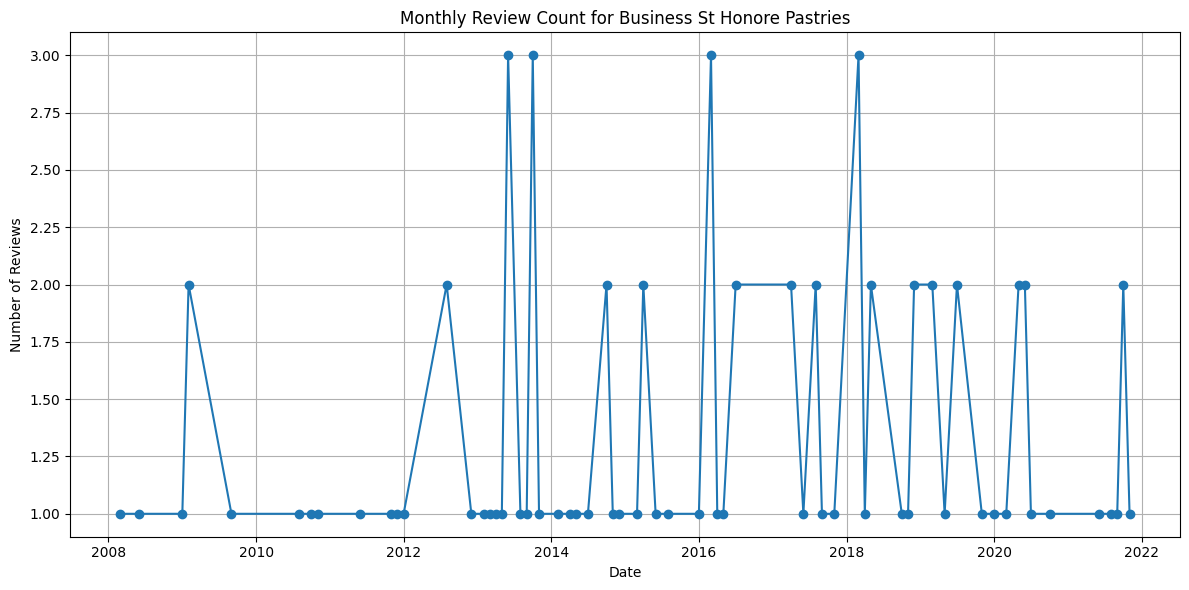

In [37]:
# === Step 3: Count reviews per month ===
review_counts = Counter(review_dates1)
review_series = pd.Series(review_counts).sort_index()
review_series.index = review_series.index.to_timestamp()

# === Step 4: Plot the time series ===
plt.figure(figsize=(12, 6))
plt.plot(review_series.index, review_series.values, marker='o')
plt.title(f"Monthly Review Count for Business {business_name1}")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.tight_layout()
plt.show()

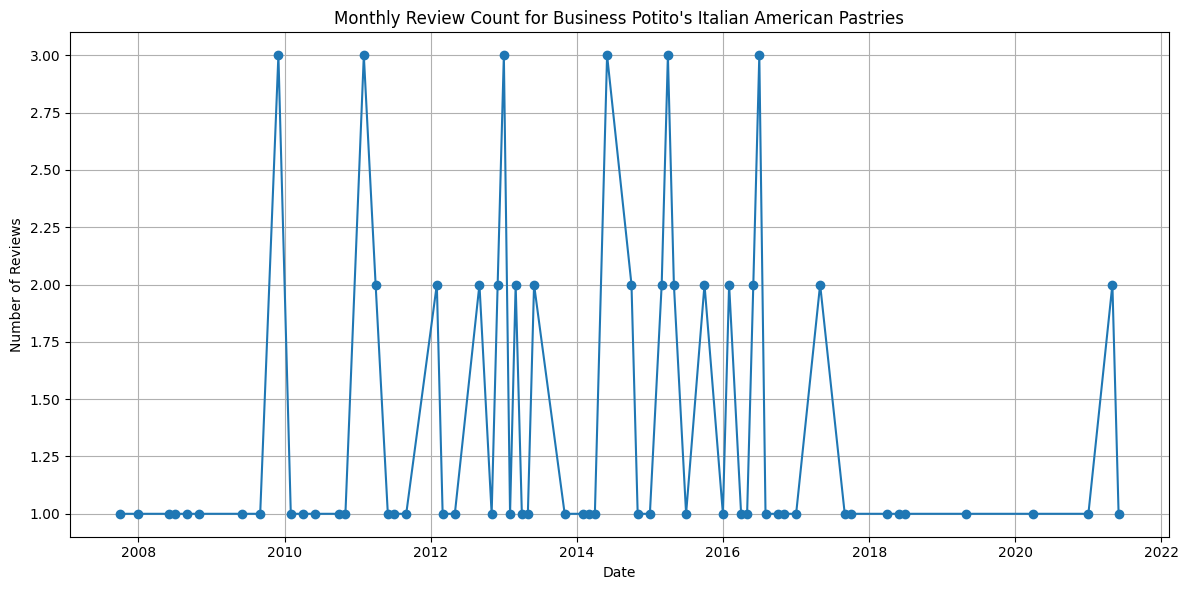

In [21]:
# === Step 3: Count reviews per month ===
review_counts = Counter(review_dates2)
review_series = pd.Series(review_counts).sort_index()
review_series.index = review_series.index.to_timestamp()

# === Step 4: Plot the time series ===
plt.figure(figsize=(12, 6))
plt.plot(review_series.index, review_series.values, marker='o')
plt.title(f"Monthly Review Count for Business {business_name2}")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.tight_layout()
plt.show()